In [1]:
import pandas as pd
tweetdata=pd.read_csv("datasets/trump-tweets.csv")
tweetdata['date'] = pd.to_datetime(tweetdata['date'])
tweetdata['time'] = tweetdata['date'].dt.time
tweetdata['hour'] = tweetdata['date'].dt.strftime('%H')
tweetdata['min'] = tweetdata['date'].dt.strftime('%M')
tweetdata['hour']=pd.to_numeric(tweetdata['hour'])
tweetdata['min']=pd.to_numeric(tweetdata['min'])
tweetdata['hour']=tweetdata['hour']+(tweetdata['min'])/60
tweetdata['date'] = pd.to_datetime(tweetdata['date']).dt.strftime('%m/%d/%Y')
tre_rate_data=pd.read_table("datasets/historical-yield-curve/YieldCurve.txt",sep="\t")
tre_rate_data['Date'] = pd.to_datetime(tre_rate_data['Date']).dt.strftime('%m/%d/%Y')
Tweet_rate_new = pd.merge(left=tweetdata , right=tre_rate_data, left_on='date', right_on='Date')
Tweet_rate_new=Tweet_rate_new.drop(['id','link','retweets','favorites','mentions','hashtags','geo','Date','min','time'],axis=1)
import numpy as np
df1=np.array(Tweet_rate_new['1 Mo'])
df1_log=[]
for x in range(len(df1)-1):
    if Tweet_rate_new['hour'][x]>15:
        if df1[x+1]>df1[x]:
            df1_log.append('up')
        elif df1[x+1]<df1[x]:
            df1_log.append('down')
        else:
            df1_log.append('neutral')
    else:
        if df1[x]>df1[x-1]:
            df1_log.append('up')
        elif df1[x]<df1[x-1]:
            df1_log.append('down')
        else:
            df1_log.append('neutral')
df11_log=df1[1:]-df1[:-1]
Tweet_rate_new=Tweet_rate_new[1:]
Tweet_rate_new['1 Mo flag']=df1_log
Tweet_rate_new['1 Mo pric diff']=df11_log
Tweet_rate_new = Tweet_rate_new[['date','hour','content','1 Mo','1 Mo flag','1 Mo pric diff']]

In [2]:
#topic modelling
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
#import spacy
Tweet_rate=Tweet_rate_new
# Load the regular expression library
import re
# Remove punctuation
Tweet_rate['content_processed'] = Tweet_rate['content'].map(lambda x: re.sub('[^\\w\\s]', ' ', x))
# Convert the titles to lowercase
Tweet_rate['content_processed'] = Tweet_rate['content_processed'].map(lambda x: x.lower())

'''
clean the text in a tweet by removing links and special characters using regex.
'''
Tweet_rate['content_processed'] = Tweet_rate['content_processed'].map(lambda x: ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split()))
  
# Remove stopwords
with open("stopwords.txt") as f:
    stopwords = f.read()
Tweet_rate['content_processed'] = [' '.join([w for w in doc.split(" ") if w not in stopwords]) for doc in Tweet_rate['content_processed']]
# Stemming(Yin: don't use this, result not very good)
# from nltk.stem.porter import *
# stemmer = PorterStemmer()
# Tweet_rate['content_processed'] = [' '.join([stemmer.stem(w) for w in doc.split(" ")]) for doc in Tweet_rate['content_processed']]

# Lemmatization 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer=WordNetLemmatizer()
Tweet_rate['content_processed'] = [' '.join([lemmatizer.lemmatize(w) for w in doc.split(" ")]) for doc in Tweet_rate['content_processed']]

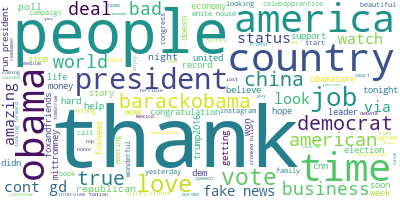

In [3]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(Tweet_rate['content_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [4]:
#NLP tagger/POS tag
#for pre-processing: delete words shorter than 4 letters
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

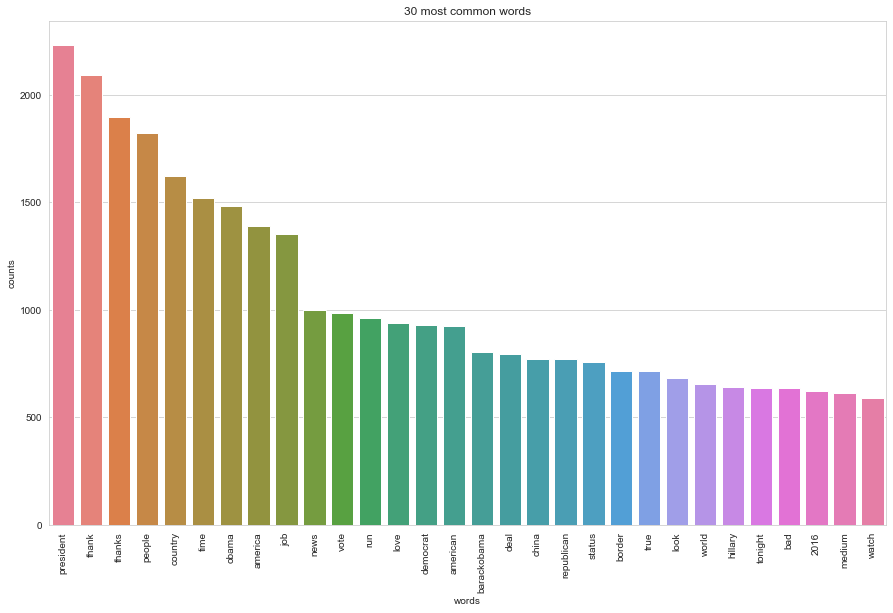

In [6]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(Tweet_rate['content_processed'])
# Visualise the 10 most common words
plot_30_most_common_words(count_data, count_vectorizer)

In [7]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [8]:
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [9]:
model_list = []

number_words = 30
for number_topics in [30]:
    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)
    # Print the topics found by the LDA model
    print("\n-----------\nTopics = " + str(number_topics) + " and Score = " + str(lda.perplexity(count_data)) + ":")
    print_topics(lda, count_vectorizer, number_words)
    model_list.append(lda)


-----------
Topics = 30 and Score = 9773.100567363588:

Topic #0:
president run country 2016 stay trump2016 people thanks mind look vote entrepreneur chuck correct speak obama schumer united office running focus lot conversation ukraine won afraid phone nancy tuned pelosi

Topic #1:
newsmax crowd medium iraq oil people isi amazing 2015 cover gop expected treat hit record 11 debate quote libya 2014 family hurricane wrong storm country local left iontv carolina american

Topic #2:
price gas child obama job thanks pay father opec son drug oil carson lot autism true proud coming ben attention fast cost program sweepstweet rising negotiation lower watch energy tahmooressi

Topic #3:
hillary clinton democrat crooked campaign witch hunt presidential collusion fbi report mueller beat russia people 2016 russian comey president hoax political james history election investigation candidate email bad justice rigged

Topic #4:
thinking enforcement chief law trumpvlog victim scott status nfl califo

In [30]:
# Use pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))

# this is a bit time consuming
LDAvis_prepared = sklearn_lda.prepare(model_list[0], count_data, count_vectorizer)

with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [10]:
#Map tweets to topic
model = model_list[0]

lda_output = model.transform(count_data)

# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)] 

# # index names
# sg_docs = [tweet.split(" ") for tweet in Tweet_rate['content_processed']]
# docnames = ["Doc" + str(i) for i in range(len(sg_docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=Tweet_rate['content_processed'])

In [11]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
Tweet_rate['dominant_topic'] = dominant_topic
# Tweet_rate['dominant_topic']

In [12]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [13]:
selected_topic = 'Topic7'

for index, row in df_document_topic.iterrows():
    if row[selected_topic] > .5:
        print(index + "\n")
df_document_topic=df_document_topic.reset_index()

apprentice randal pinkett lieutenant governor mvovzb

interview week greta van susteren available slightly abridged form 96ztoa info

hootie821 wishn2bfamous khfritch question answered trumpvlog glp9ib

therealteenusa saturday 8pm missteenusa teenusa

book midas touch robert kiyosaki rich dad poor dad bookstore tomorrow cont deck vkqh7

record 6 7 american living extreme poverty tragic

washington simply incapable moderation barackobama extreme leftist defeated timetogettough

deal timetogettough opus available dec 5th

book tell harsh truth lay bold plan time america 1 timetogettough

newtgingrich tower thinker

forty six million american time history country live poverty line timetogettough

signing copy book time tough tomorrow dec 9th tower 11 cont deck jjins

signing copy book time tough tomorrow tower 11 2 pm hope

signing copy book time tough tower 11 2 pm hope timetogettough

look line started join book signing timetogettough starting 11am 2 pm tower

crowd tower timetogettough

hhshkmohd people uae support enthusiasm fuelled victory dubai expo2020 congratulation fantastic

claim lied obama living uncle wasn mentioned book guess bill ayers

screenplaywritr gore ship

lutherice tie amazing

dustinjm19 retweet tie purchase macy tomorrow

hope enjoy story highly respected estate weeklyhttp 1kegjl1

edwardfcox robastorino intent york suicide mission

unionleader piece jdistaso visit saintanselm necouncil nhiop politics egg 1esy0pv

information university victory call alan garten esquire 212 836 3203 jeff goldman esquire 212 867 4466

experience knowledge prescience formidable combination power underestimate champion

set bar possibly focused disciplined alert single

thank jeffrey lord article discrediting third rate buzzfeed site slimebag reporter mckay coppins piersmorgan amspec

thank matt boyle breitbartnews analytical written piece sleazebag blogger mckaycoppins irrelevant buzzfeed

thank jeffrey lord amspec incredible insightful article weekend failing irrel

national gop presidential poll via oann 35 6 trump2016https gravismarketing status 659053593975246853

polling bencarson support sept head tomorrow cnbc republicandebate pollinghub status 659229328983502848 photo 1pic wx3ty29i3p

thank gopdebate makeamericagreatagain drudgereport now1 htm ub8xqapdzz

dad drudge report yes

kingster73 rubio irresponsible finance doesn hire american people

syoka68 reading comment leftist make nauseated america

maryland4t smallbiz4trump american kind rallying jldonaldtrump help makeamericagreatagain

truth continues 14 truth medium tell trump2016http breitbart journalism 2015 12 01 7 piece documentation vindicate trump claim 911 muslim celebration

saragreenwell votetrump2016 chris christie apologize 2 else doubted teamtrump

endlessmike03 oreillyfactor omg awesome time zone

majorcbs major garrett cbsnews cover inaccurately total agenda bad reporter

poll wasn thank gopdebatepic yljgkooebg

join tomorrow dubuque iowa iacaucus trump2016https eventbrite 

amazing bennyjohnson status 1180524380985679872

si5hz81asl

stlouisblues amazing comeback reminds lose faith hard support believe yourself victory reach stlbluespic qef54kquak

confirmed abu bakr baghdadi replacement terminated american troop top spot dead

kkufwsirai

job trumpwarroom status 1212391791774838784

book nedryun status 1205122585274523648

republican fighting citizen background race religion color creed movement american believe fairness justice equality dignity opportunity safety tent party idea future 8gib5ekmof



In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
Tweet_rate['SA_int'] = np.array([analyzer.polarity_scores(tweet) for tweet in Tweet_rate['content_processed'] ])
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        return "Positive" 
  
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative" 
  
    else : 
        return "Neutral"
df3={"content_processed":Tweet_rate['content_processed']}

In [16]:
df4=[]
for i in df3['content_processed']:
    df4.append(sentiment_scores(i))
Tweet_rate['SA']=df4

In [18]:
pos_tweets=Tweet_rate[(Tweet_rate['SA']=='Positive')]
neu_tweets=Tweet_rate[(Tweet_rate['SA']=='Neutral')]
neg_tweets=Tweet_rate[(Tweet_rate['SA']=='Negative')]
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(Tweet_rate['content_processed'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(Tweet_rate['content_processed'])))
print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(Tweet_rate['content_processed'])))

Percentage of positive tweets: 50.02001786209233%
Percentage of neutral tweets: 23.95676141788057%
Percentage of negative tweets: 26.0232207200271%


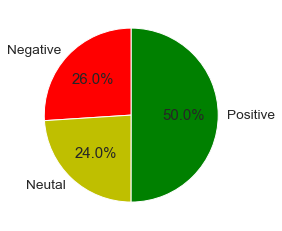

In [19]:
import matplotlib.pyplot as plt
all_tweets = [len(neg_tweets), len(neu_tweets), len(pos_tweets)]
categories = ['Negative', 'Neutal','Positive']
colors = ['r','y','g']
plt.pie(all_tweets, labels=categories, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

No handles with labels found to put in legend.


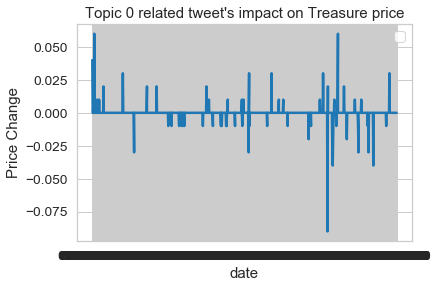

No handles with labels found to put in legend.


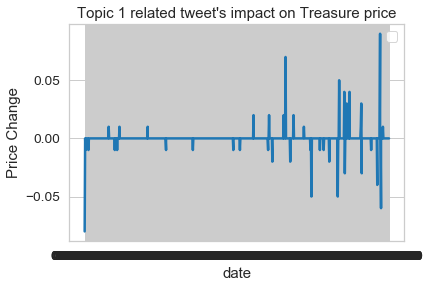

No handles with labels found to put in legend.


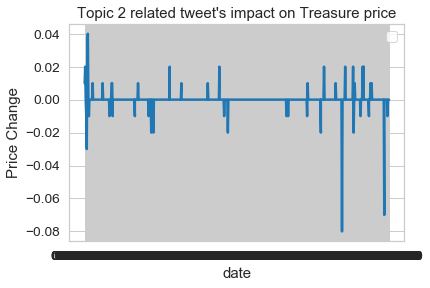

No handles with labels found to put in legend.


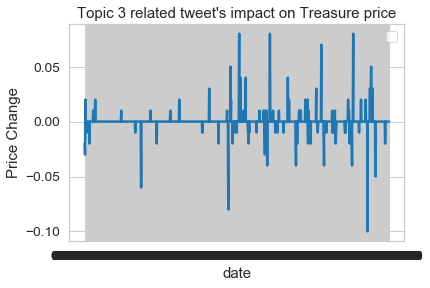

No handles with labels found to put in legend.


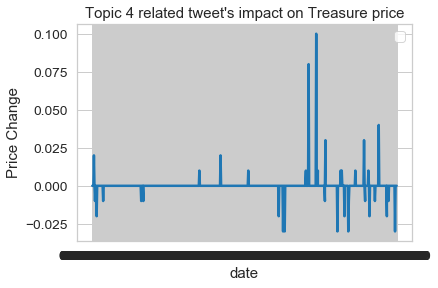

No handles with labels found to put in legend.


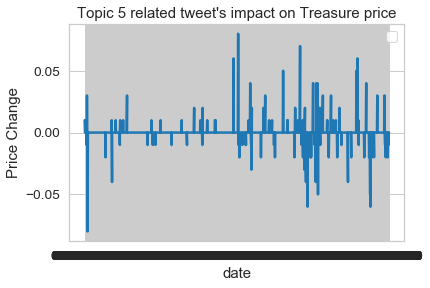

No handles with labels found to put in legend.


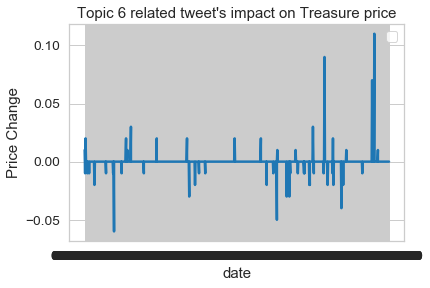

No handles with labels found to put in legend.


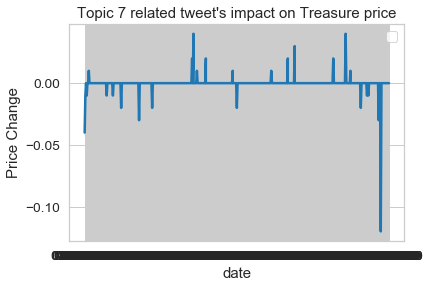

No handles with labels found to put in legend.


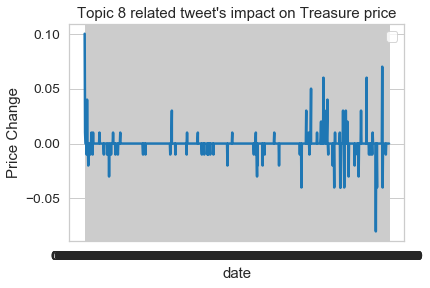

No handles with labels found to put in legend.


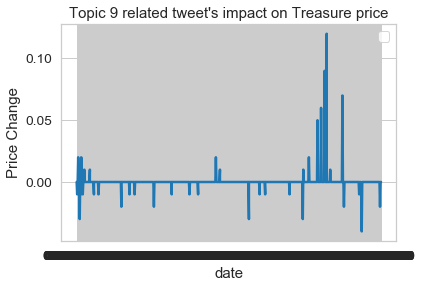

No handles with labels found to put in legend.


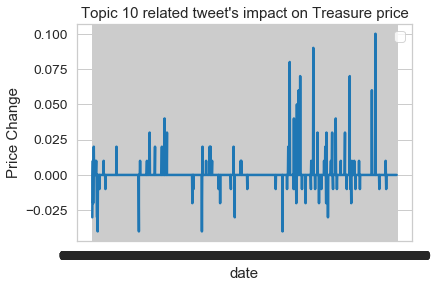

No handles with labels found to put in legend.


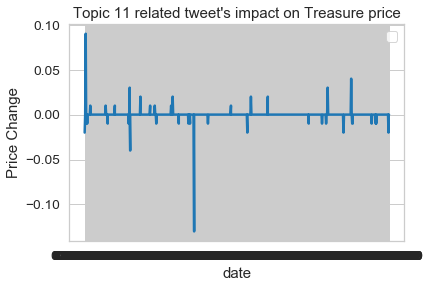

No handles with labels found to put in legend.


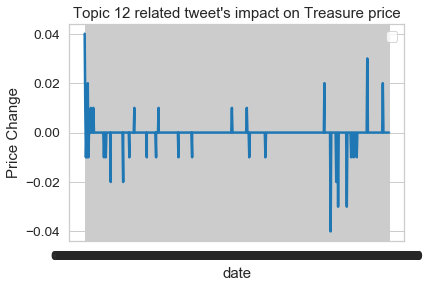

No handles with labels found to put in legend.


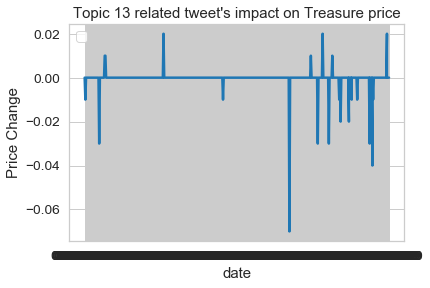

No handles with labels found to put in legend.


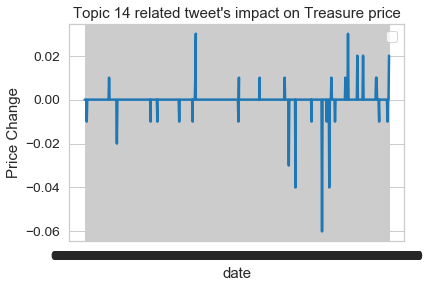

No handles with labels found to put in legend.


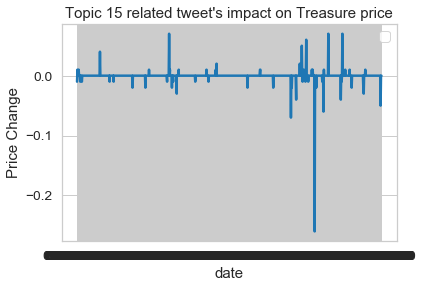

No handles with labels found to put in legend.


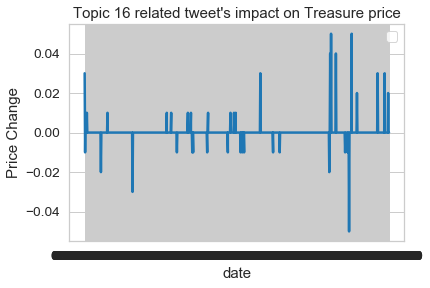

No handles with labels found to put in legend.


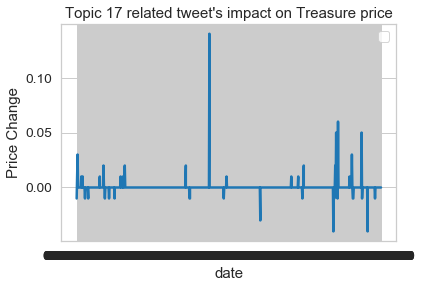

No handles with labels found to put in legend.


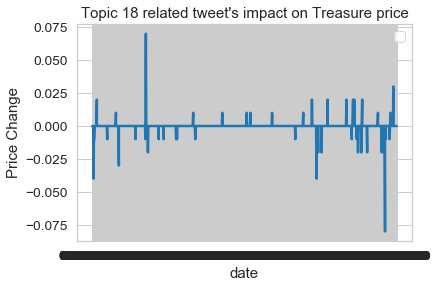

No handles with labels found to put in legend.


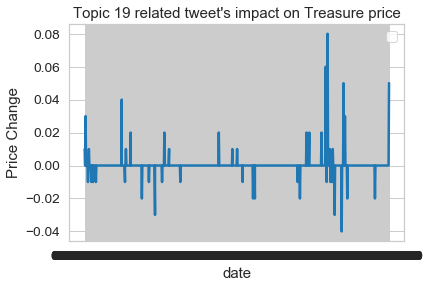

No handles with labels found to put in legend.


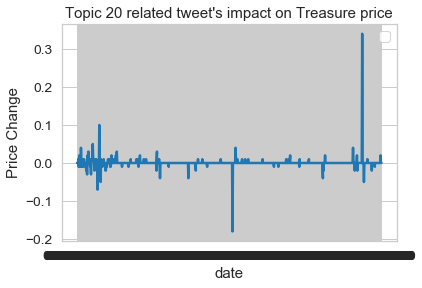

No handles with labels found to put in legend.


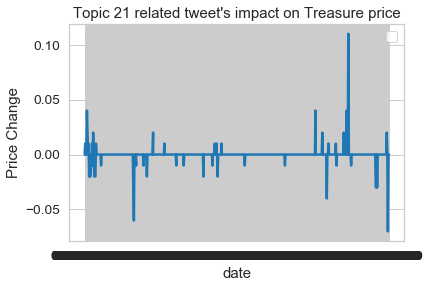

No handles with labels found to put in legend.


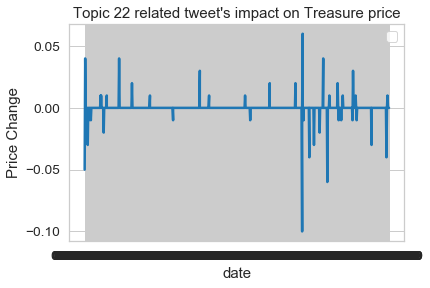

No handles with labels found to put in legend.


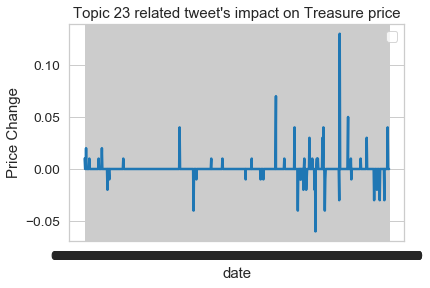

No handles with labels found to put in legend.


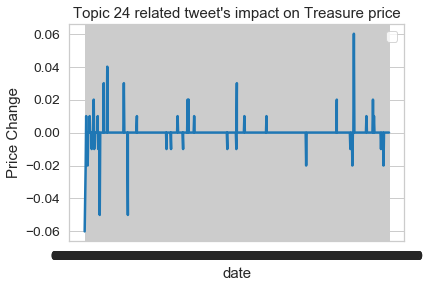

No handles with labels found to put in legend.


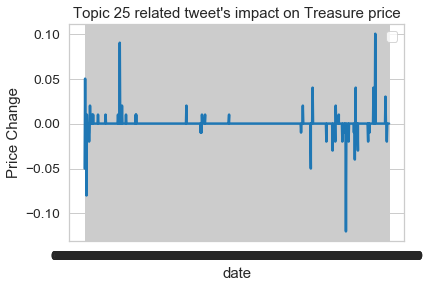

No handles with labels found to put in legend.


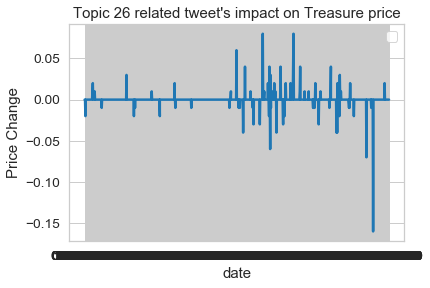

No handles with labels found to put in legend.


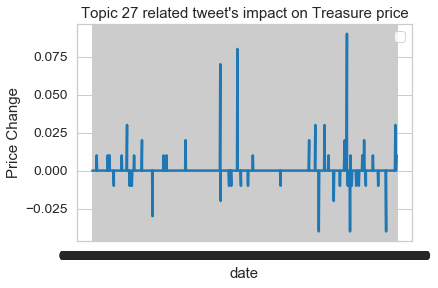

No handles with labels found to put in legend.


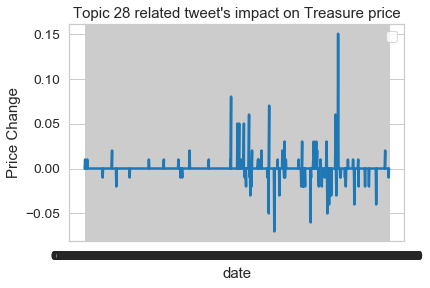

No handles with labels found to put in legend.


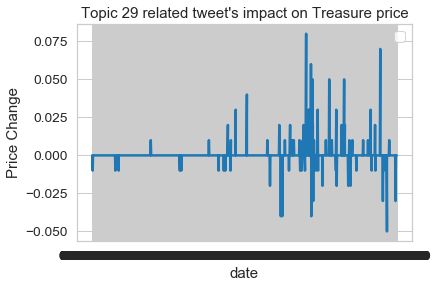

In [20]:
###################################
#EDA - Topic impact on price movement

for i in set(list(Tweet_rate['dominant_topic'])):
    df5=pd.DataFrame()
    df5=Tweet_rate[(Tweet_rate['dominant_topic']==i)]
    plt.plot(df5['date'], df5['1 Mo pric diff'])
    plt.xlabel('date')
    plt.ylabel('Price Change')
    plt.title(f"Topic {i} related tweet's impact on Treasure price")
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


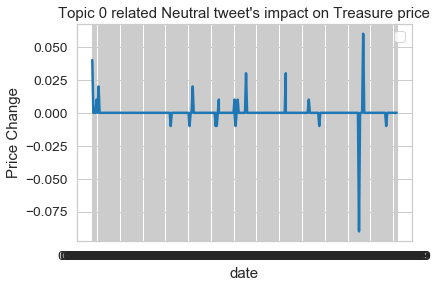

No handles with labels found to put in legend.


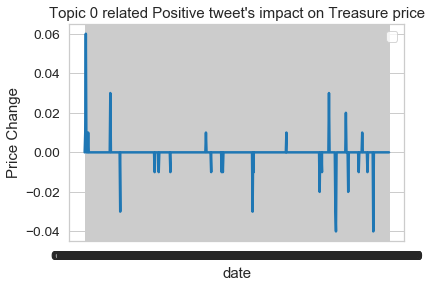

No handles with labels found to put in legend.


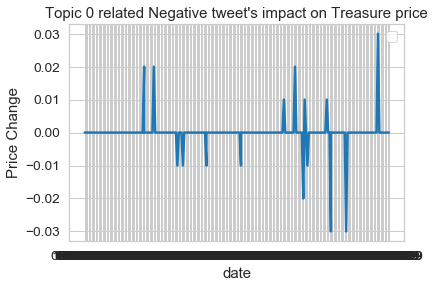

No handles with labels found to put in legend.


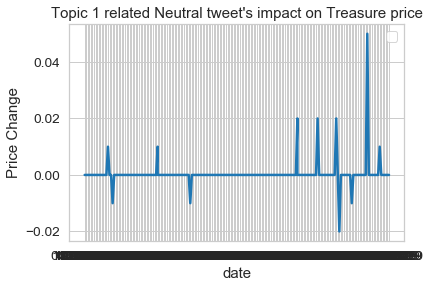

No handles with labels found to put in legend.


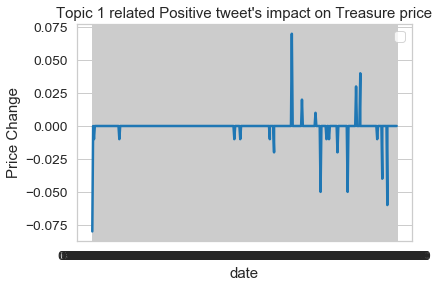

No handles with labels found to put in legend.


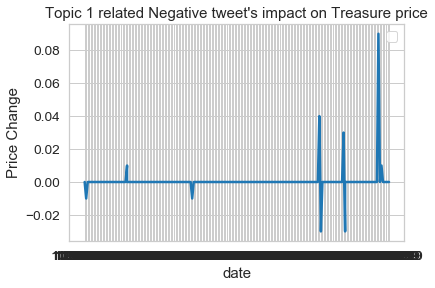

No handles with labels found to put in legend.


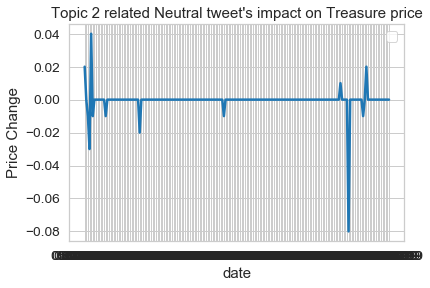

No handles with labels found to put in legend.


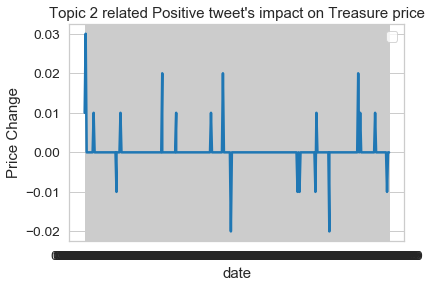

No handles with labels found to put in legend.


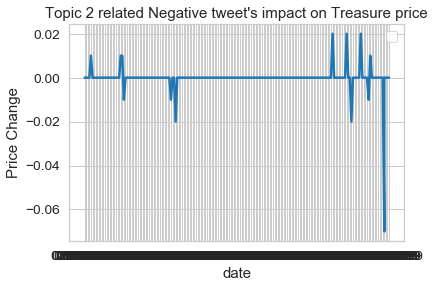

No handles with labels found to put in legend.


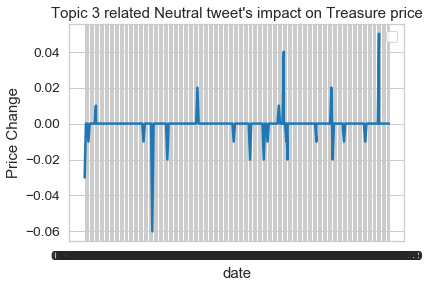

No handles with labels found to put in legend.


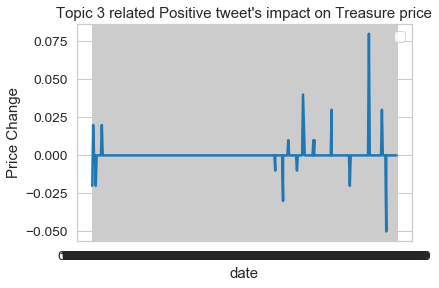

No handles with labels found to put in legend.


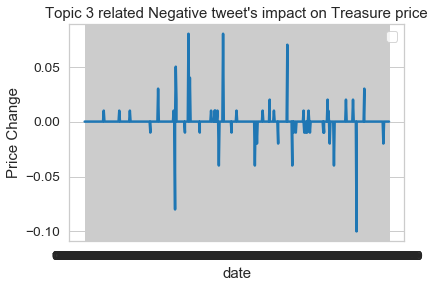

No handles with labels found to put in legend.


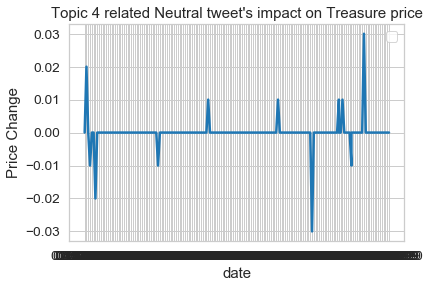

No handles with labels found to put in legend.


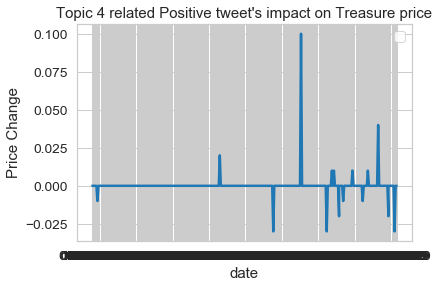

No handles with labels found to put in legend.


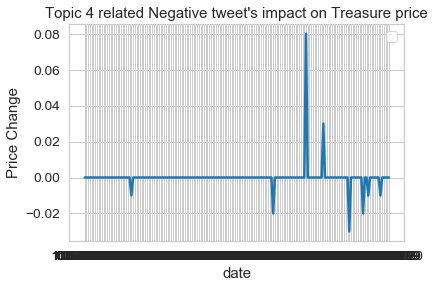

No handles with labels found to put in legend.


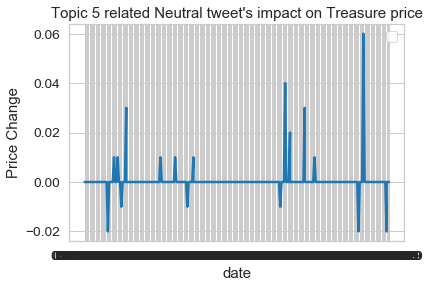

No handles with labels found to put in legend.


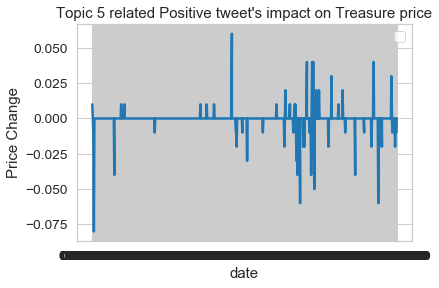

No handles with labels found to put in legend.


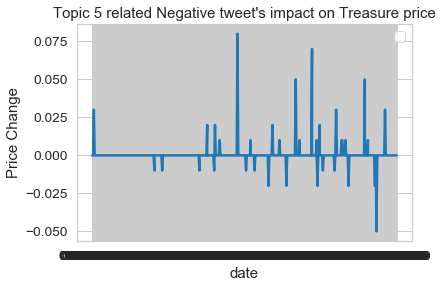

No handles with labels found to put in legend.


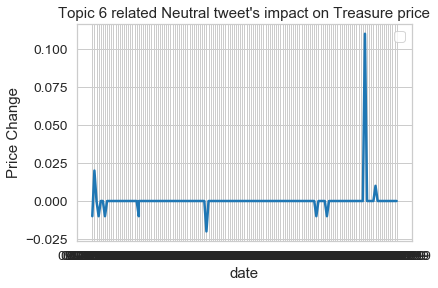

No handles with labels found to put in legend.


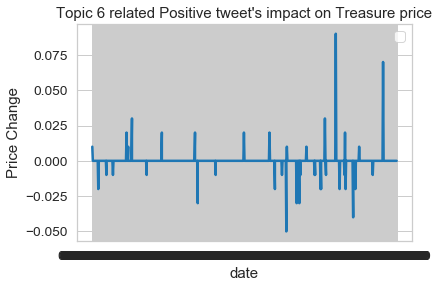

No handles with labels found to put in legend.


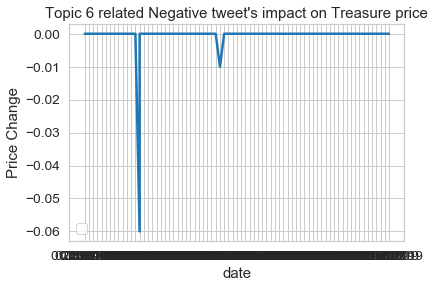

No handles with labels found to put in legend.


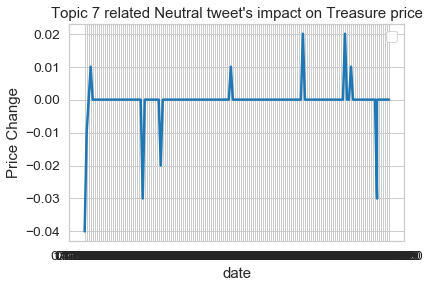

No handles with labels found to put in legend.


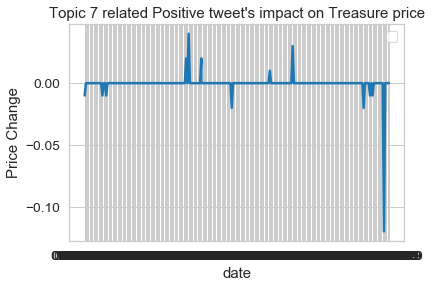

No handles with labels found to put in legend.


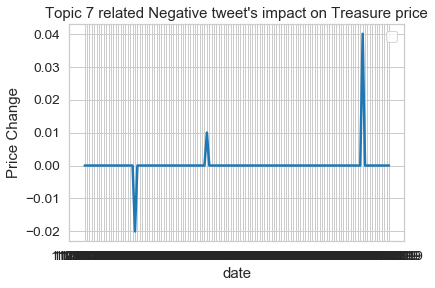

No handles with labels found to put in legend.


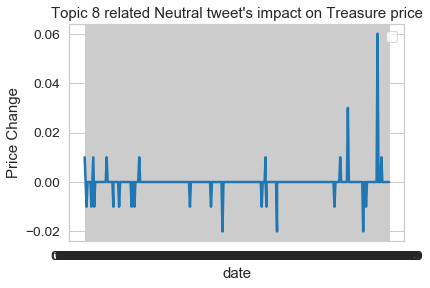

No handles with labels found to put in legend.


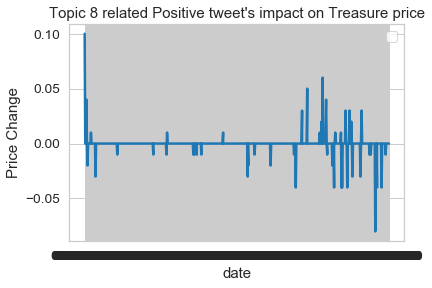

No handles with labels found to put in legend.


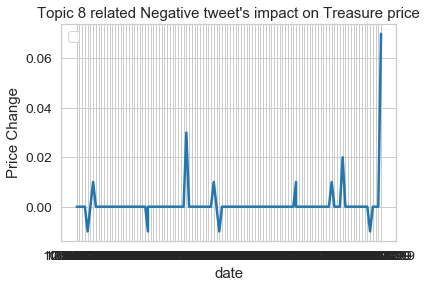

No handles with labels found to put in legend.


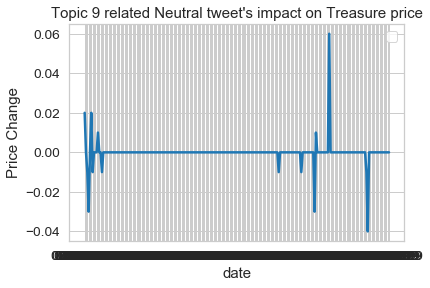

No handles with labels found to put in legend.


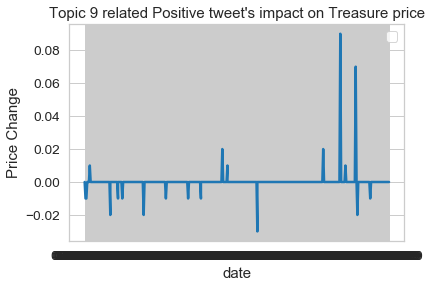

No handles with labels found to put in legend.


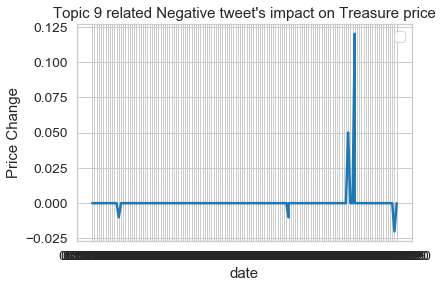

No handles with labels found to put in legend.


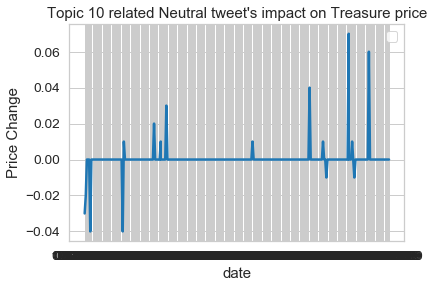

No handles with labels found to put in legend.


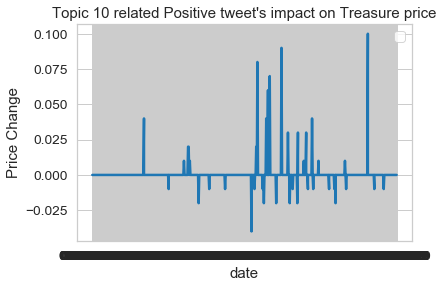

No handles with labels found to put in legend.


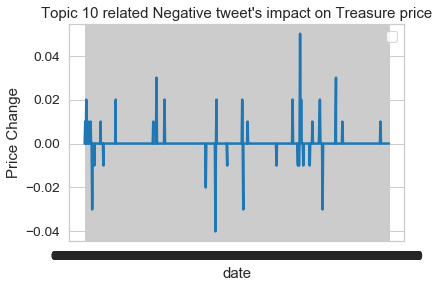

No handles with labels found to put in legend.


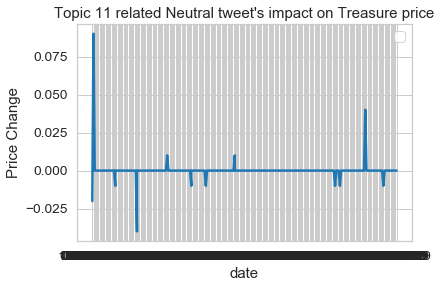

No handles with labels found to put in legend.


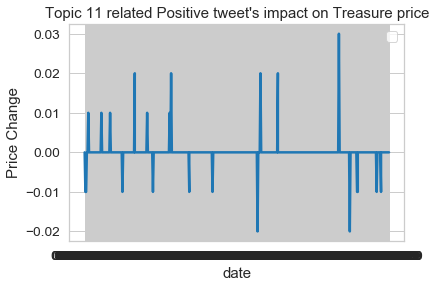

No handles with labels found to put in legend.


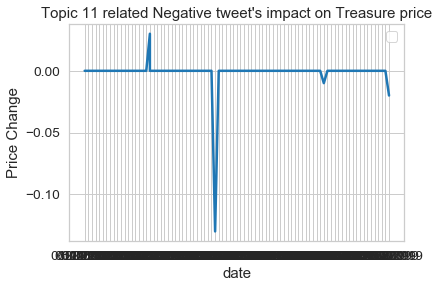

No handles with labels found to put in legend.


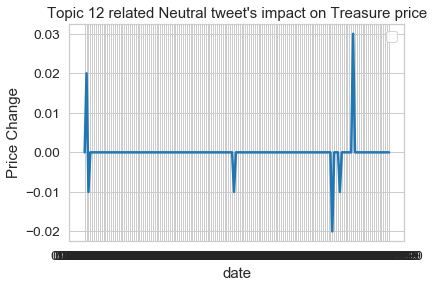

No handles with labels found to put in legend.


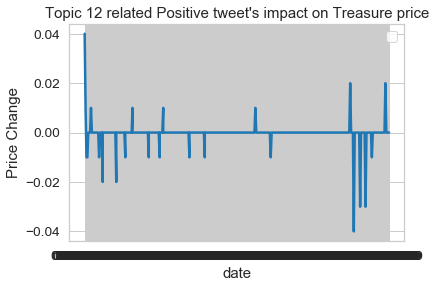

No handles with labels found to put in legend.


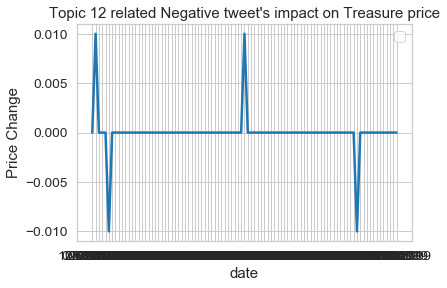

No handles with labels found to put in legend.


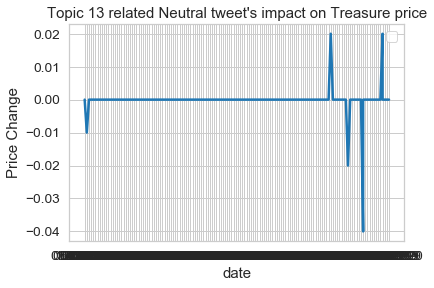

No handles with labels found to put in legend.


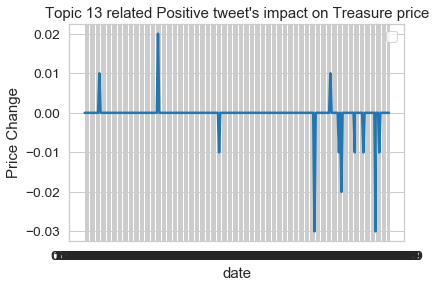

No handles with labels found to put in legend.


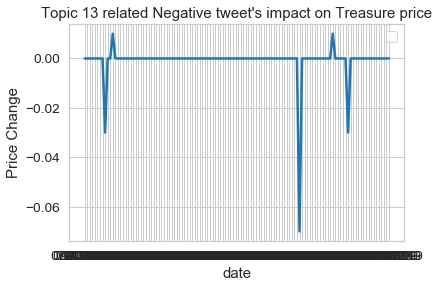

No handles with labels found to put in legend.


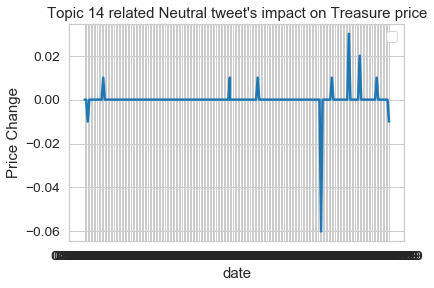

No handles with labels found to put in legend.


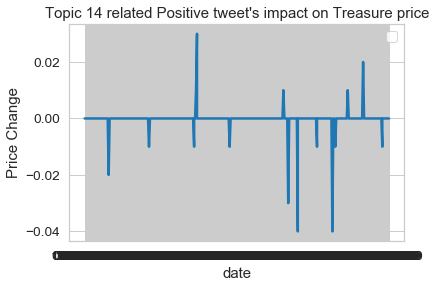

No handles with labels found to put in legend.


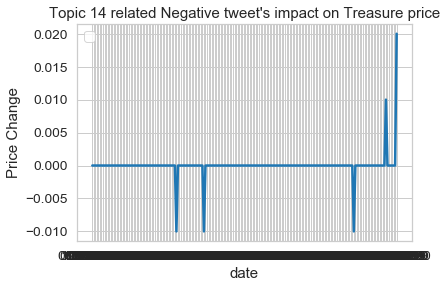

No handles with labels found to put in legend.


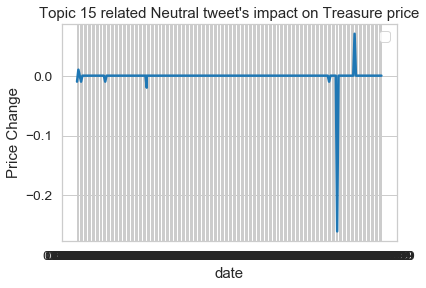

No handles with labels found to put in legend.


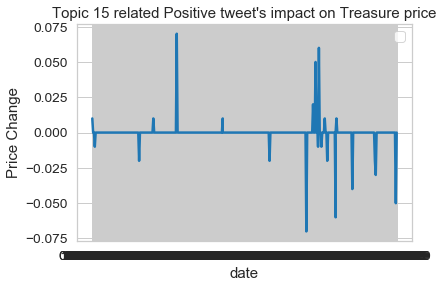

No handles with labels found to put in legend.


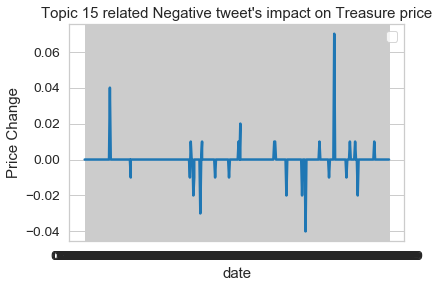

No handles with labels found to put in legend.


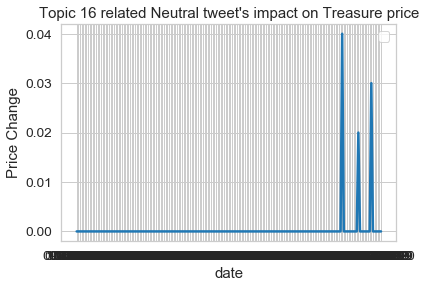

No handles with labels found to put in legend.


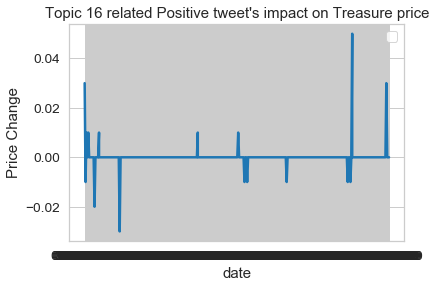

No handles with labels found to put in legend.


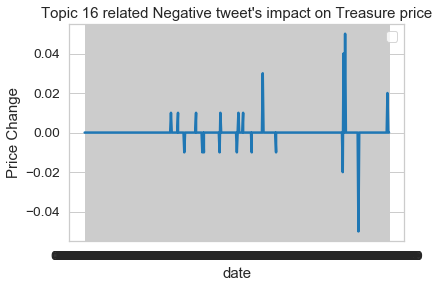

No handles with labels found to put in legend.


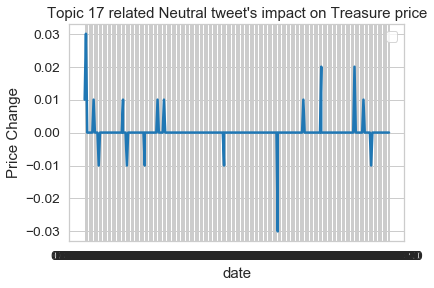

No handles with labels found to put in legend.


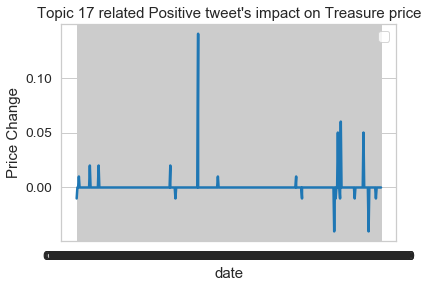

No handles with labels found to put in legend.


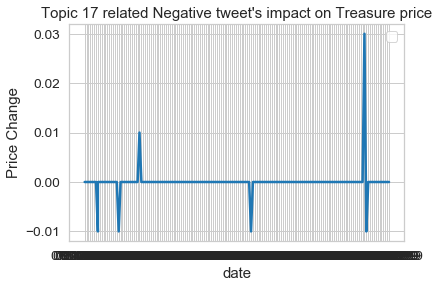

No handles with labels found to put in legend.


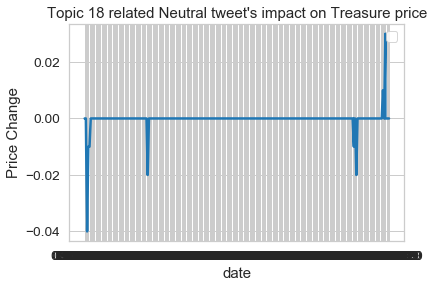

No handles with labels found to put in legend.


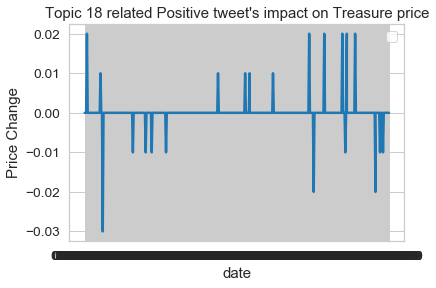

No handles with labels found to put in legend.


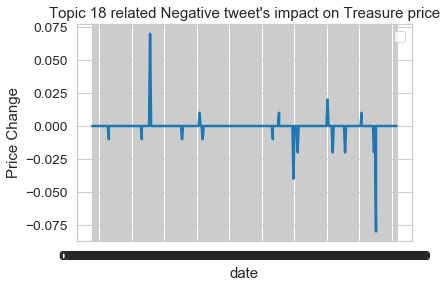

No handles with labels found to put in legend.


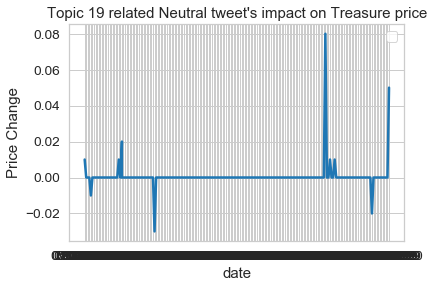

No handles with labels found to put in legend.


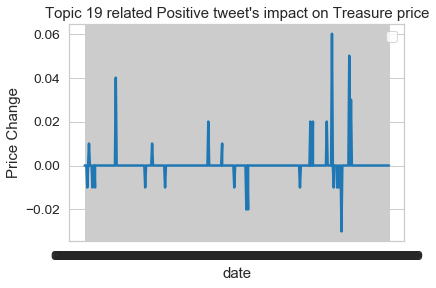

No handles with labels found to put in legend.


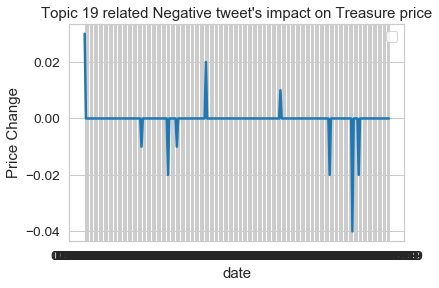

No handles with labels found to put in legend.


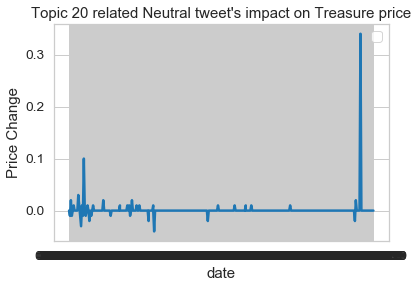

No handles with labels found to put in legend.


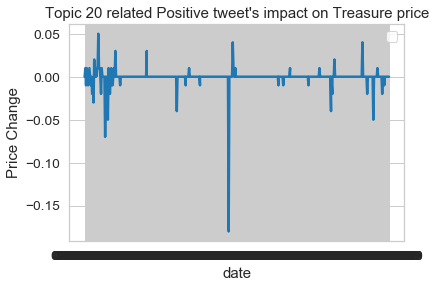

No handles with labels found to put in legend.


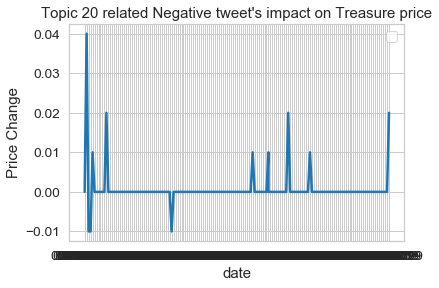

No handles with labels found to put in legend.


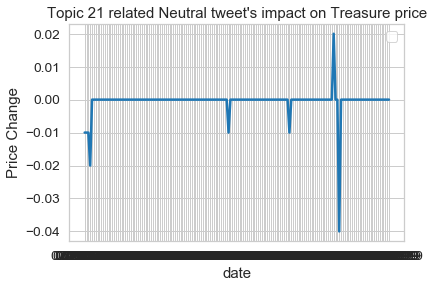

No handles with labels found to put in legend.


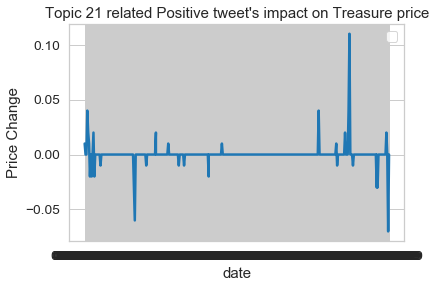

No handles with labels found to put in legend.


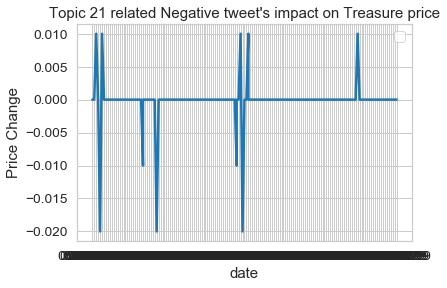

No handles with labels found to put in legend.


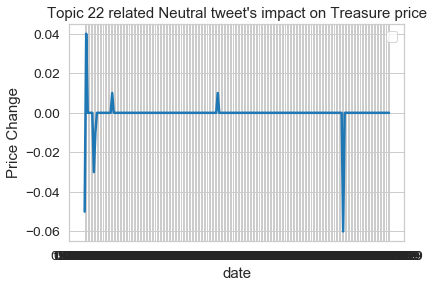

No handles with labels found to put in legend.


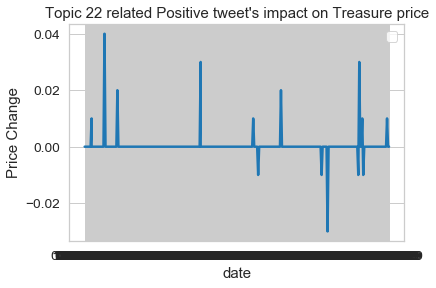

No handles with labels found to put in legend.


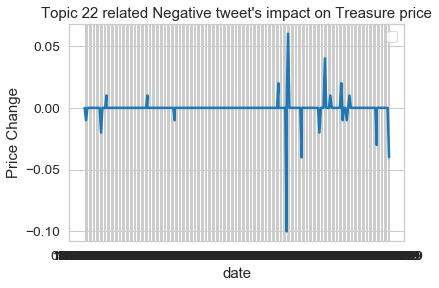

No handles with labels found to put in legend.


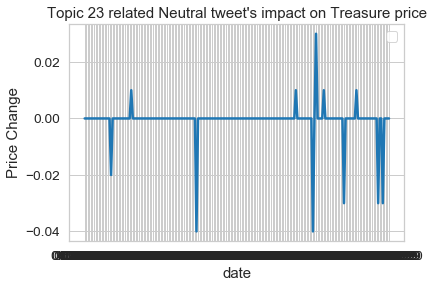

No handles with labels found to put in legend.


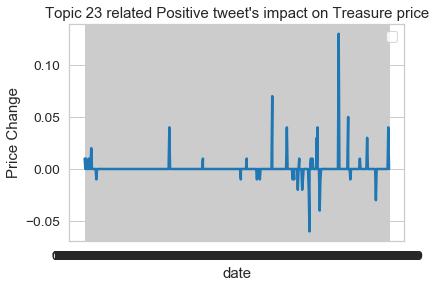

No handles with labels found to put in legend.


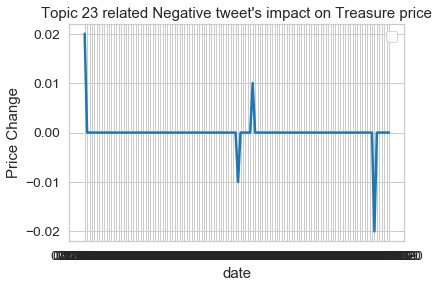

No handles with labels found to put in legend.


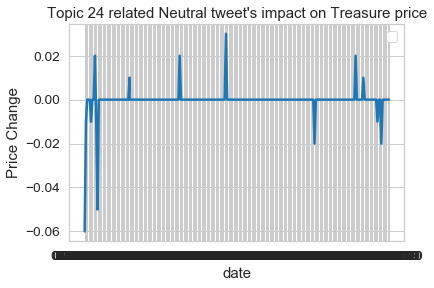

No handles with labels found to put in legend.


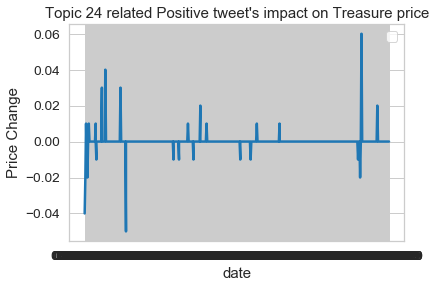

No handles with labels found to put in legend.


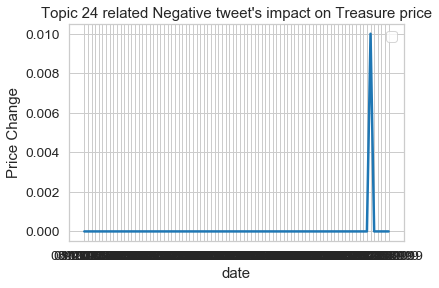

No handles with labels found to put in legend.


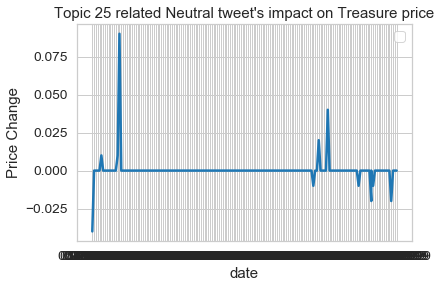

No handles with labels found to put in legend.


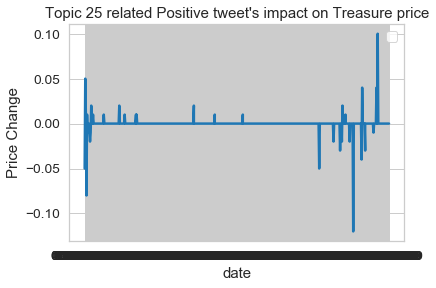

No handles with labels found to put in legend.


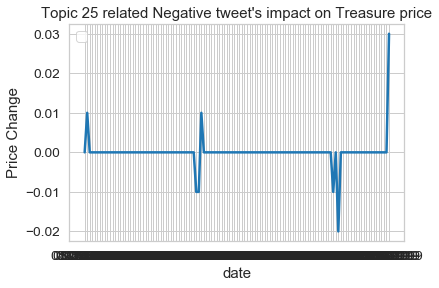

No handles with labels found to put in legend.


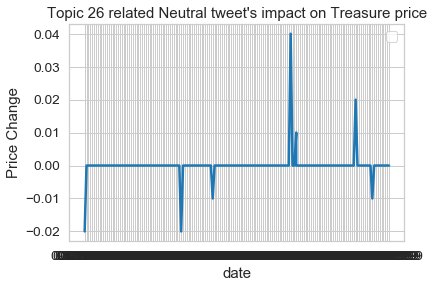

No handles with labels found to put in legend.


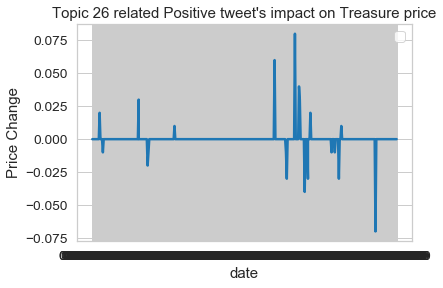

No handles with labels found to put in legend.


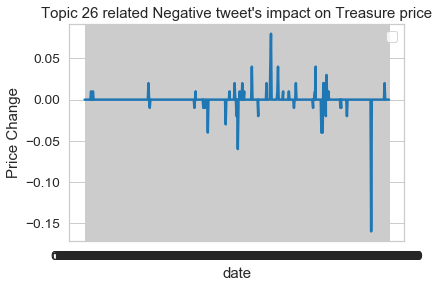

No handles with labels found to put in legend.


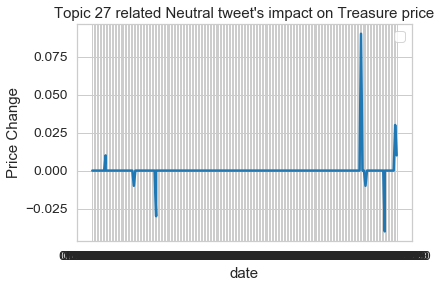

No handles with labels found to put in legend.


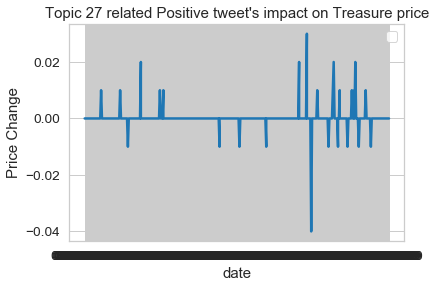

No handles with labels found to put in legend.


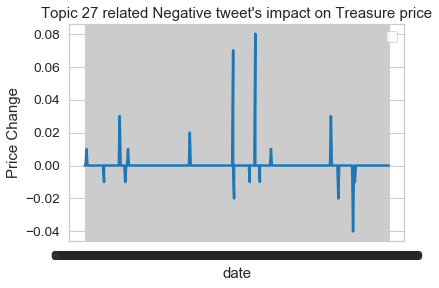

No handles with labels found to put in legend.


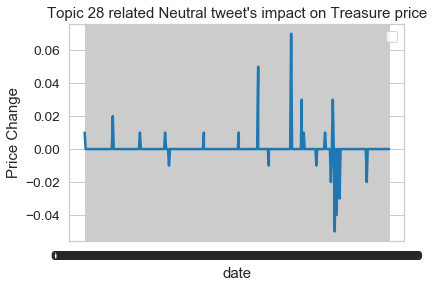

No handles with labels found to put in legend.


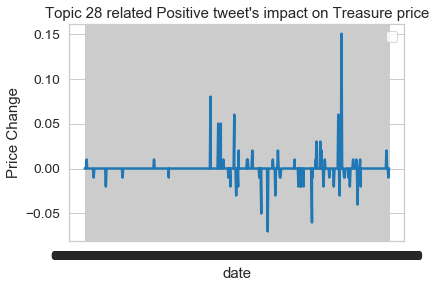

No handles with labels found to put in legend.


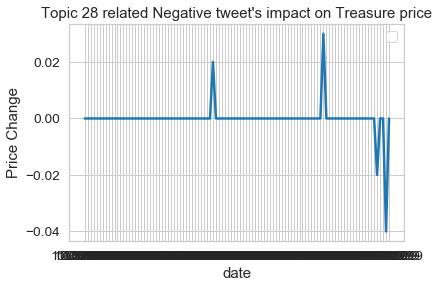

No handles with labels found to put in legend.


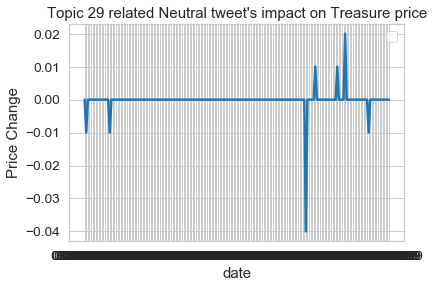

No handles with labels found to put in legend.


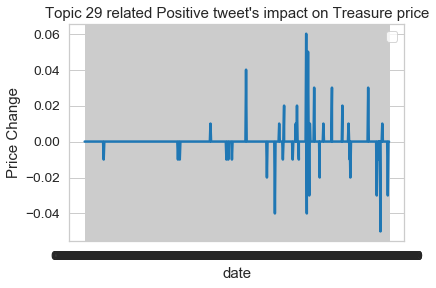

No handles with labels found to put in legend.


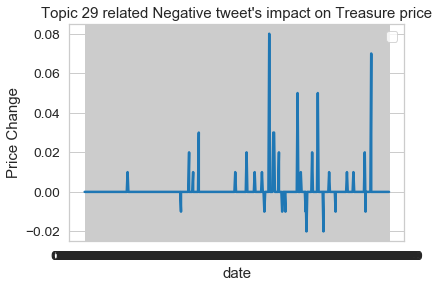

In [21]:
################################################################
#EDA - Topic Sentiment impact on price movement

for i in set(list(Tweet_rate['dominant_topic'])):
    for j in set(list(Tweet_rate['SA'])):
        df5=pd.DataFrame()
        df5=Tweet_rate[(Tweet_rate['dominant_topic']==i) & (Tweet_rate['SA']==j)]
        plt.plot(df5['date'], df5['1 Mo pric diff'])
        plt.xlabel('date')
        plt.ylabel('Price Change')
        plt.title(f"Topic {i} related {j} tweet's impact on Treasure price")
        plt.legend()
        plt.show()

In [22]:
############################
#removing rows with no price movement and neutral tweets
df6=Tweet_rate_new[(Tweet_rate_new['1 Mo flag']!="neutral") & (Tweet_rate_new['SA']!="Neutral")]

No handles with labels found to put in legend.


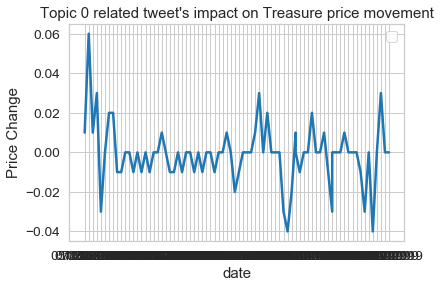

No handles with labels found to put in legend.


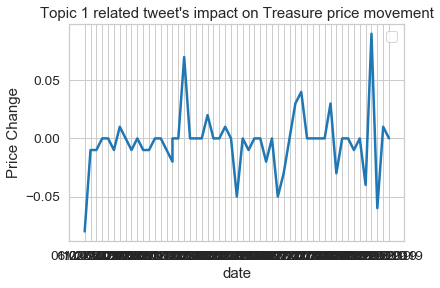

No handles with labels found to put in legend.


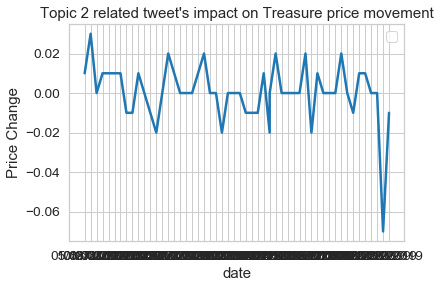

No handles with labels found to put in legend.


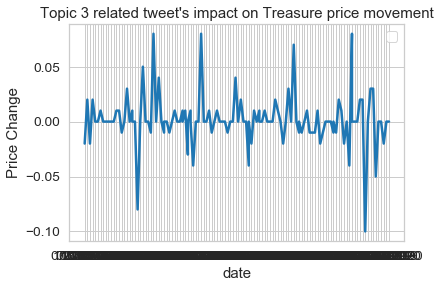

No handles with labels found to put in legend.


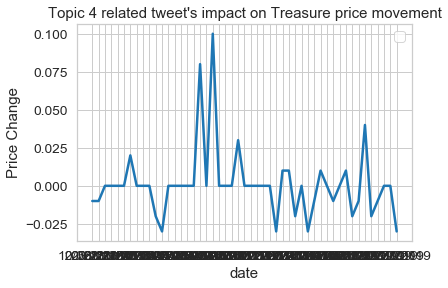

No handles with labels found to put in legend.


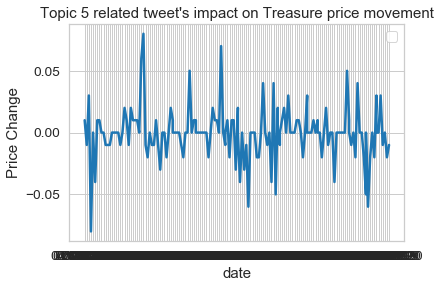

No handles with labels found to put in legend.


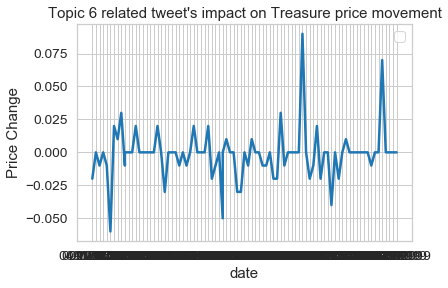

No handles with labels found to put in legend.


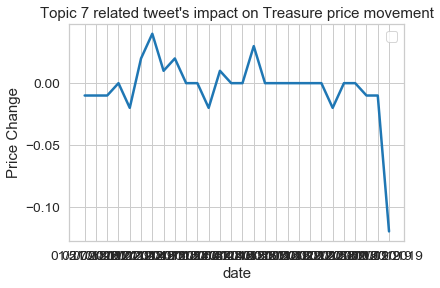

No handles with labels found to put in legend.


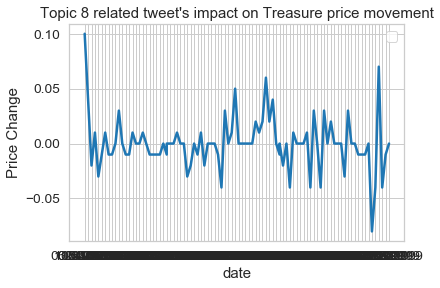

No handles with labels found to put in legend.


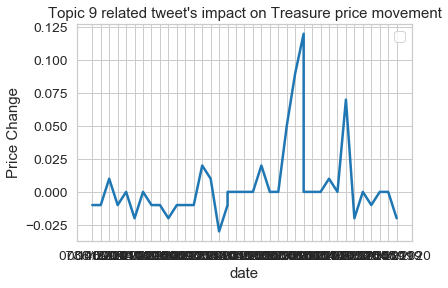

No handles with labels found to put in legend.


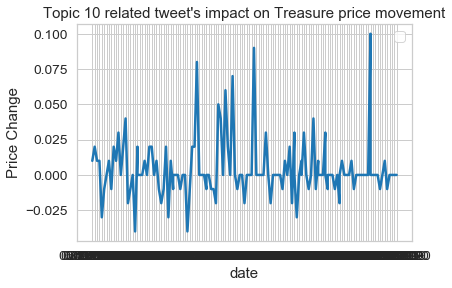

No handles with labels found to put in legend.


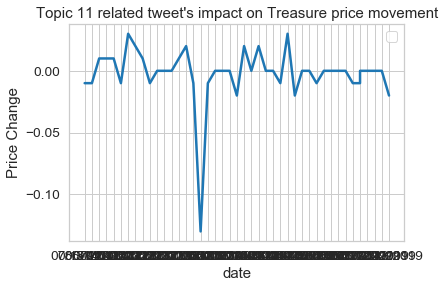

No handles with labels found to put in legend.


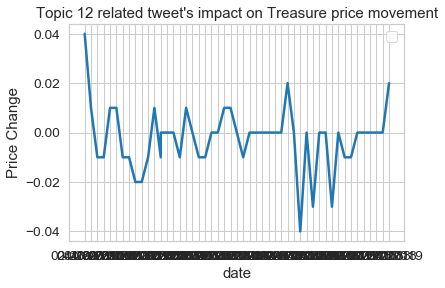

No handles with labels found to put in legend.


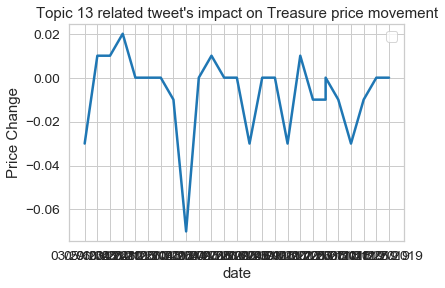

No handles with labels found to put in legend.


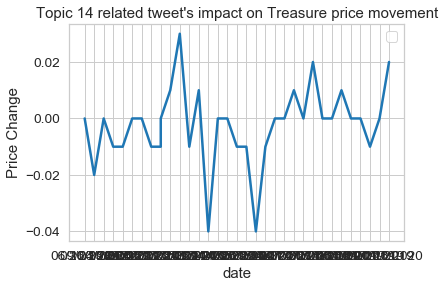

No handles with labels found to put in legend.


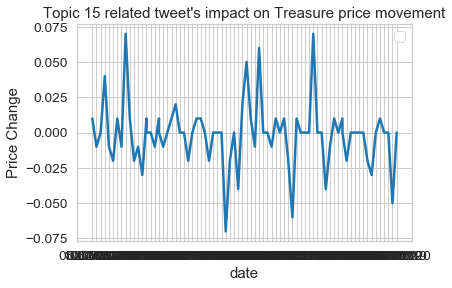

No handles with labels found to put in legend.


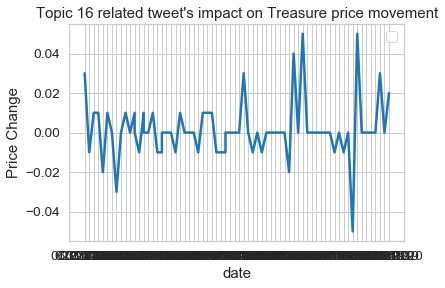

No handles with labels found to put in legend.


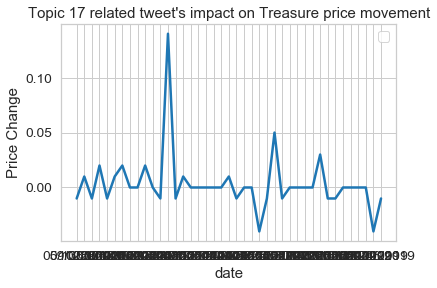

No handles with labels found to put in legend.


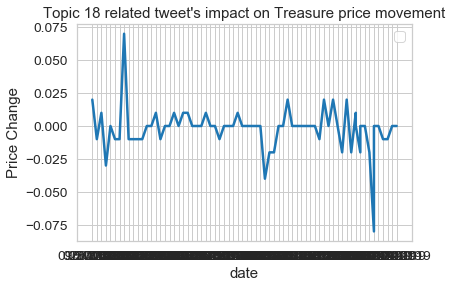

No handles with labels found to put in legend.


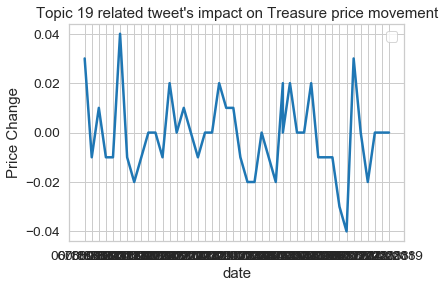

No handles with labels found to put in legend.


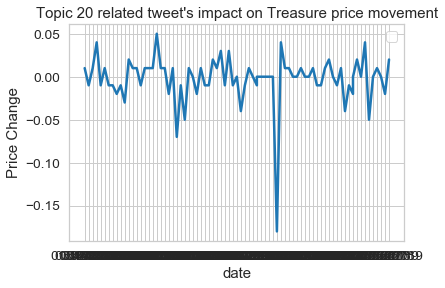

No handles with labels found to put in legend.


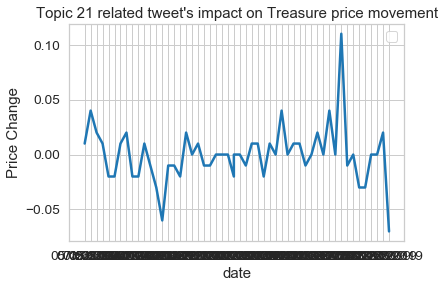

No handles with labels found to put in legend.


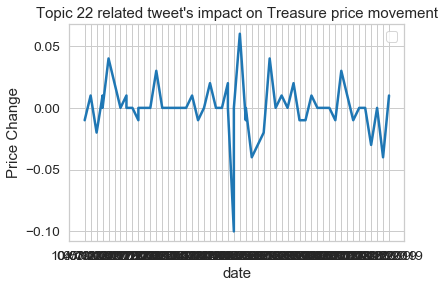

No handles with labels found to put in legend.


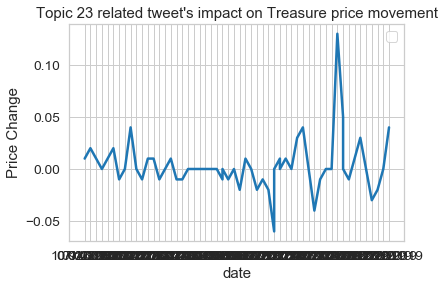

No handles with labels found to put in legend.


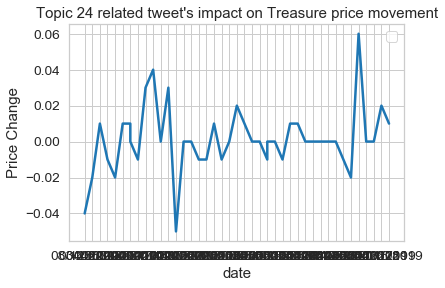

No handles with labels found to put in legend.


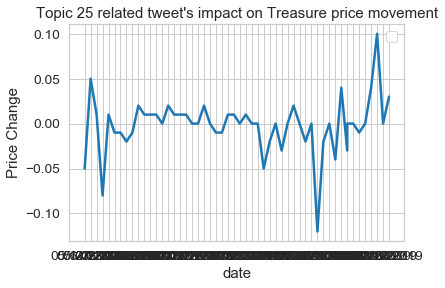

No handles with labels found to put in legend.


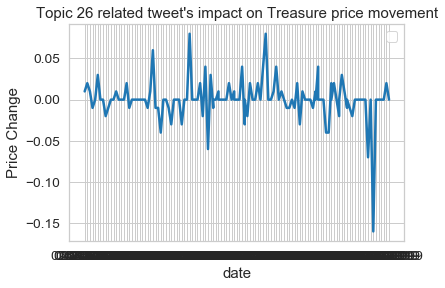

No handles with labels found to put in legend.


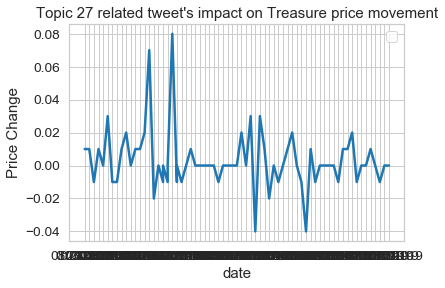

No handles with labels found to put in legend.


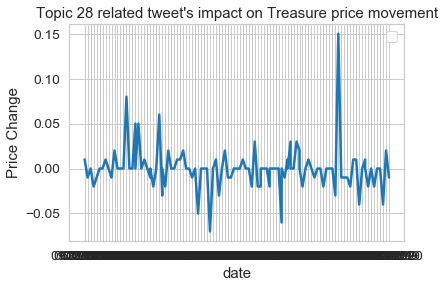

No handles with labels found to put in legend.


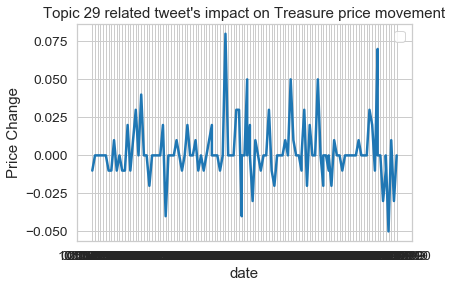

In [23]:
############
#EDA - Topic impact on price movement
for i in set(list(df6['dominant_topic'])):
    df5_1=pd.DataFrame()
    df5_1=df6[(df6['dominant_topic']==i)]
    plt.plot(df5_1['date'], df5_1['1 Mo pric diff'])
    plt.xlabel('date')
    plt.ylabel('Price Change')
    plt.title(f"Topic {i} related tweet's impact on Treasure price movement")
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


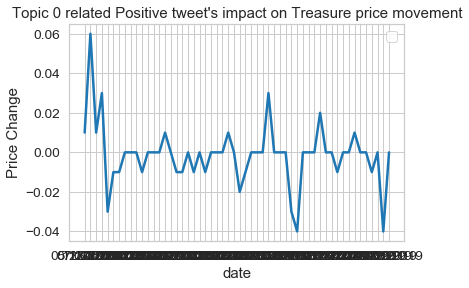

No handles with labels found to put in legend.


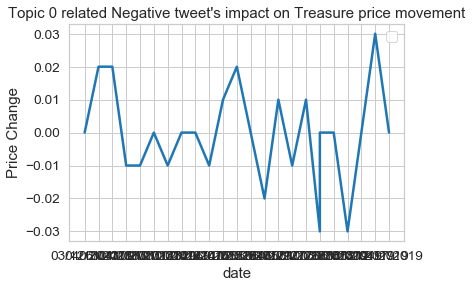

No handles with labels found to put in legend.


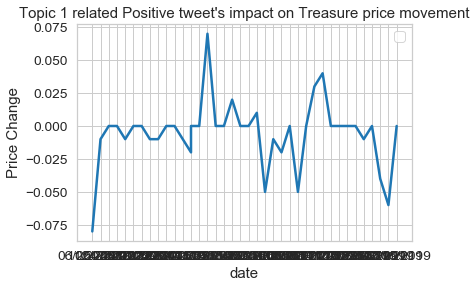

No handles with labels found to put in legend.


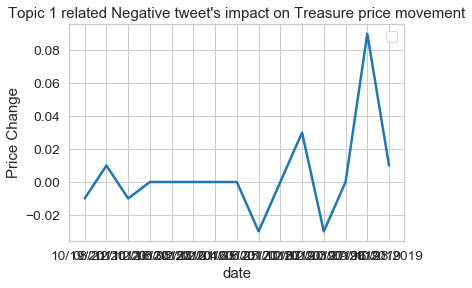

No handles with labels found to put in legend.


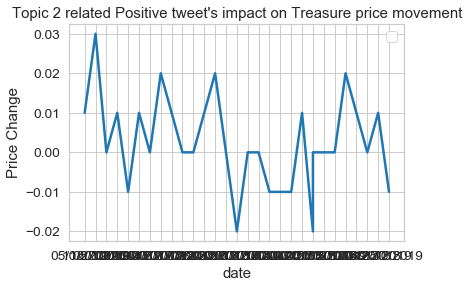

No handles with labels found to put in legend.


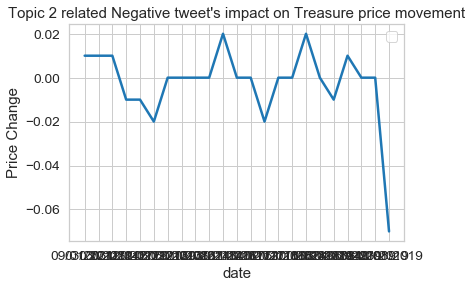

No handles with labels found to put in legend.


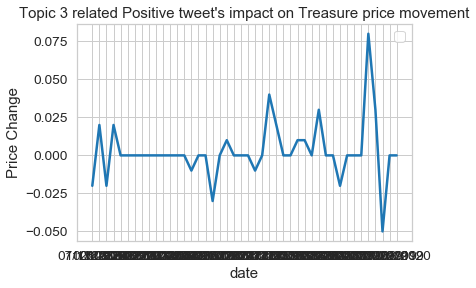

No handles with labels found to put in legend.


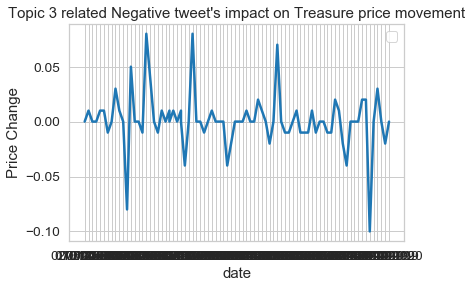

No handles with labels found to put in legend.


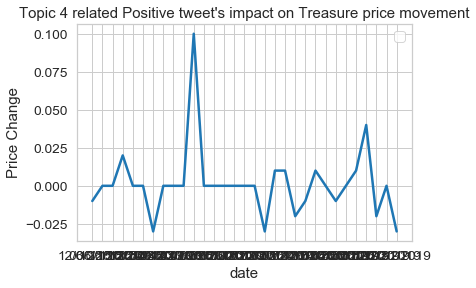

No handles with labels found to put in legend.


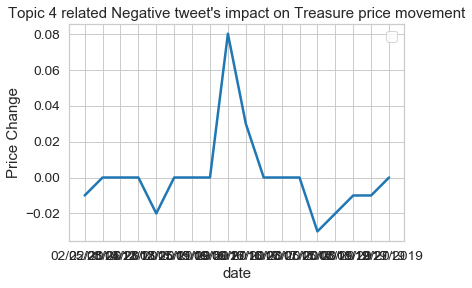

No handles with labels found to put in legend.


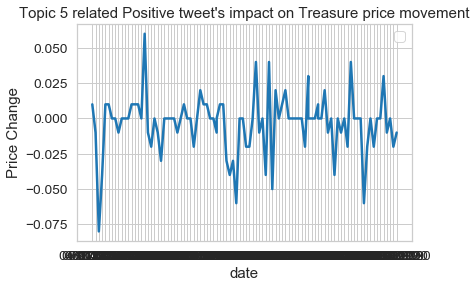

No handles with labels found to put in legend.


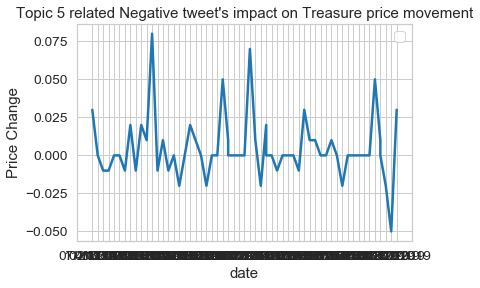

No handles with labels found to put in legend.


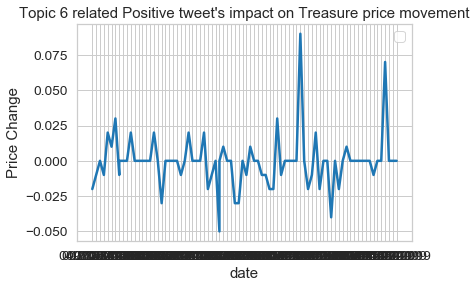

No handles with labels found to put in legend.


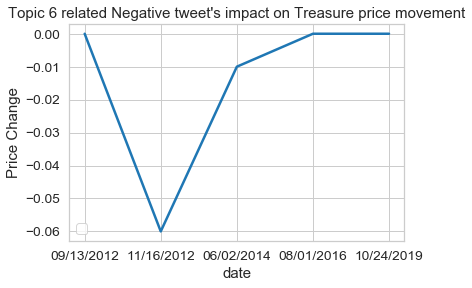

No handles with labels found to put in legend.


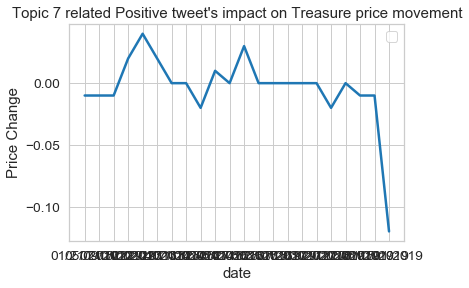

No handles with labels found to put in legend.


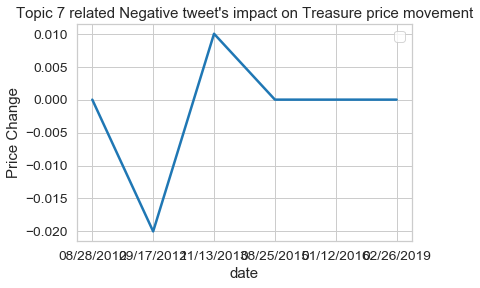

No handles with labels found to put in legend.


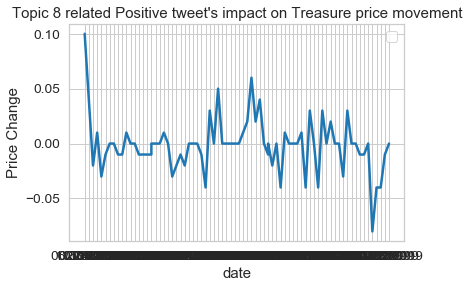

No handles with labels found to put in legend.


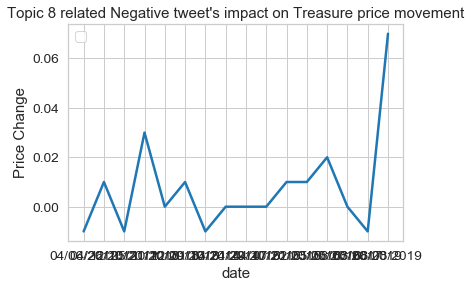

No handles with labels found to put in legend.


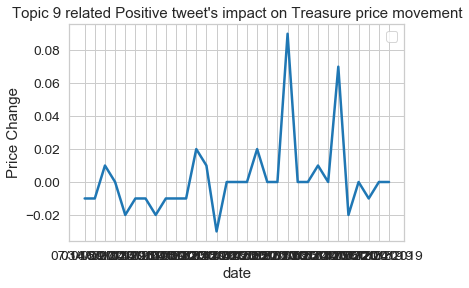

No handles with labels found to put in legend.


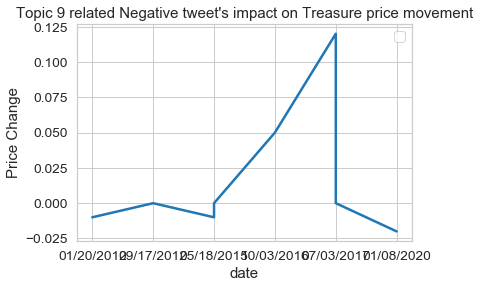

No handles with labels found to put in legend.


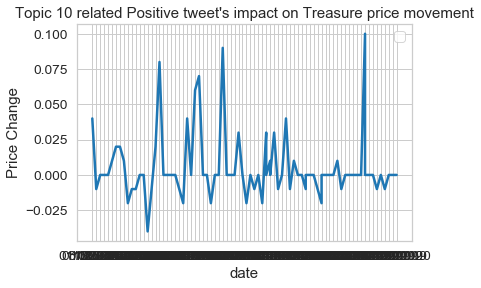

No handles with labels found to put in legend.


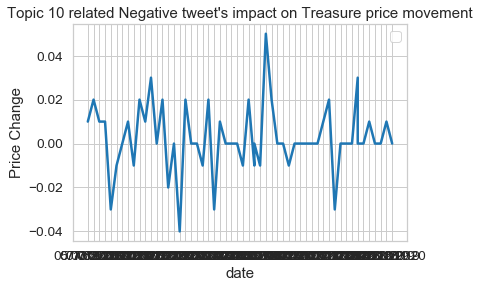

No handles with labels found to put in legend.


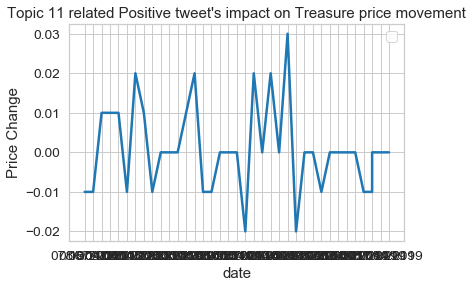

No handles with labels found to put in legend.


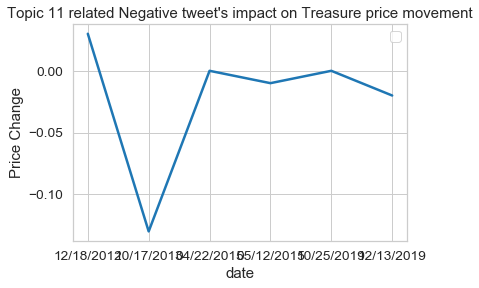

No handles with labels found to put in legend.


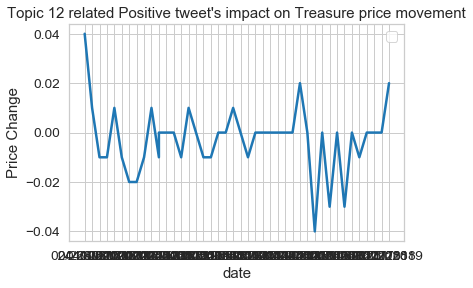

No handles with labels found to put in legend.


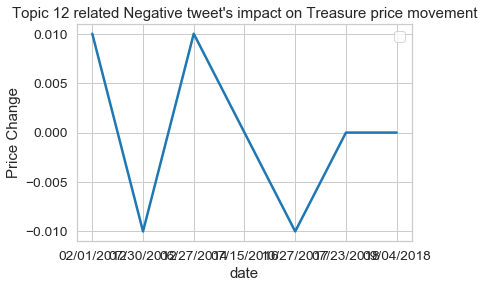

No handles with labels found to put in legend.


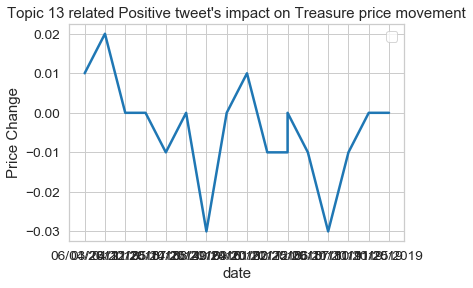

No handles with labels found to put in legend.


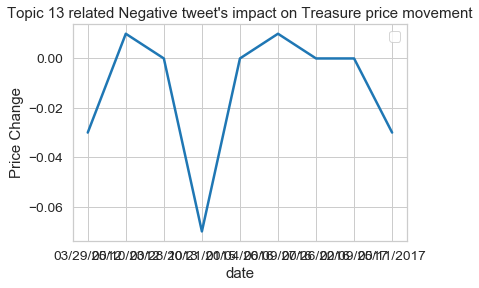

No handles with labels found to put in legend.


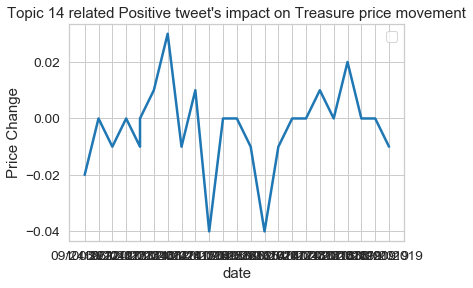

No handles with labels found to put in legend.


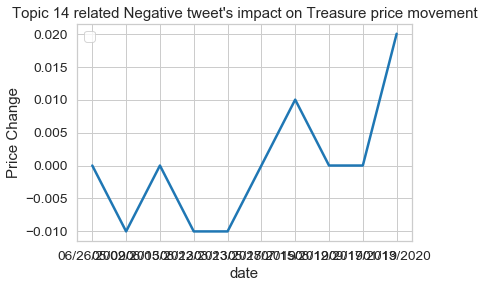

No handles with labels found to put in legend.


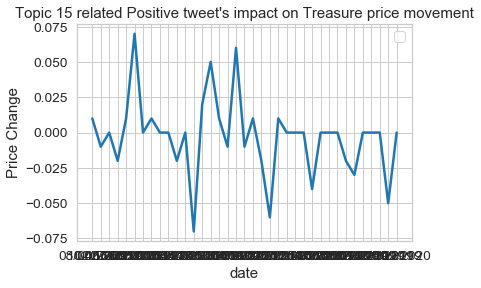

No handles with labels found to put in legend.


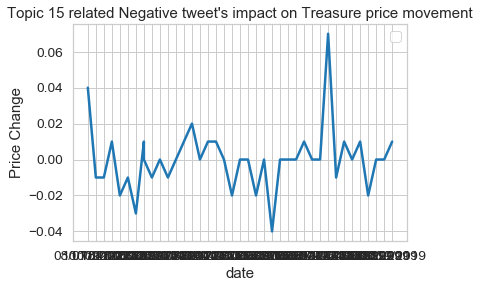

No handles with labels found to put in legend.


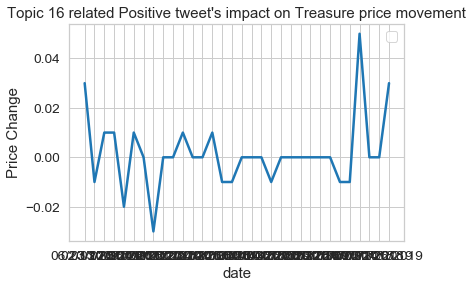

No handles with labels found to put in legend.


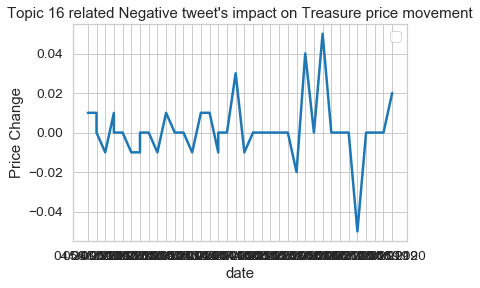

No handles with labels found to put in legend.


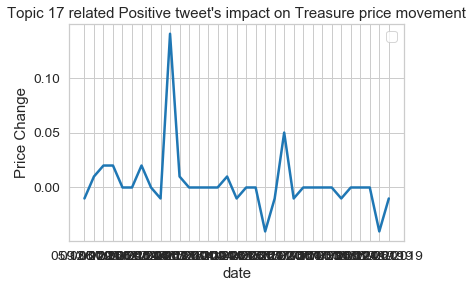

No handles with labels found to put in legend.


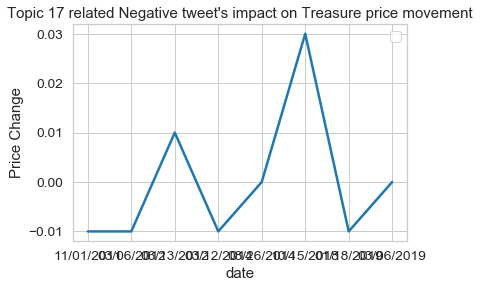

No handles with labels found to put in legend.


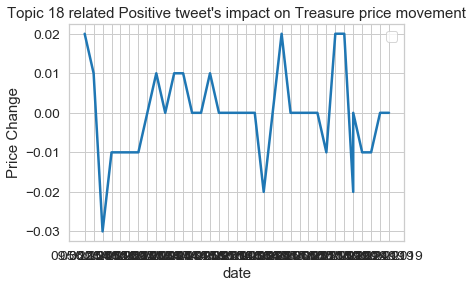

No handles with labels found to put in legend.


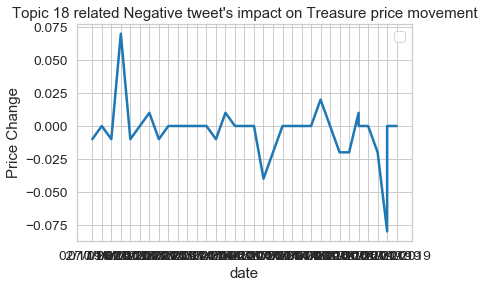

No handles with labels found to put in legend.


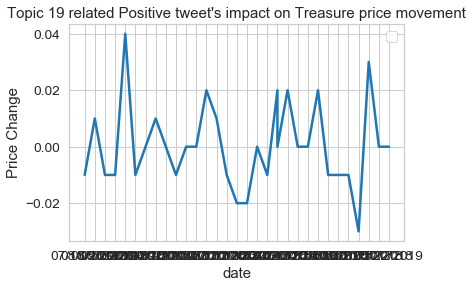

No handles with labels found to put in legend.


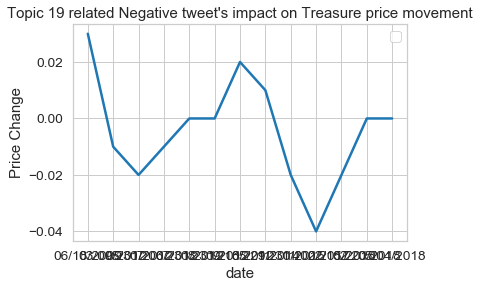

No handles with labels found to put in legend.


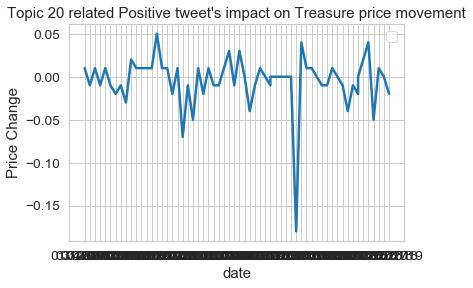

No handles with labels found to put in legend.


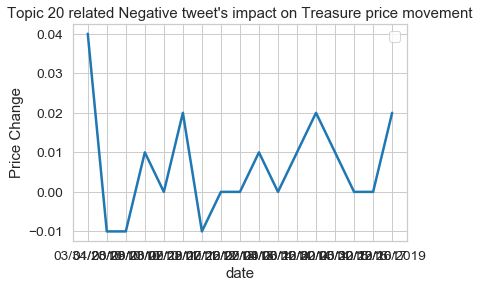

No handles with labels found to put in legend.


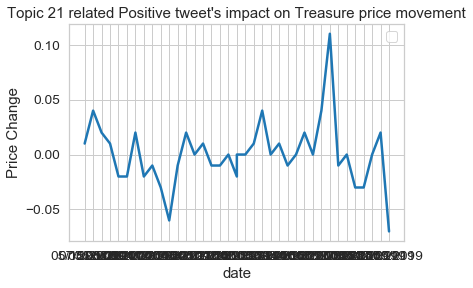

No handles with labels found to put in legend.


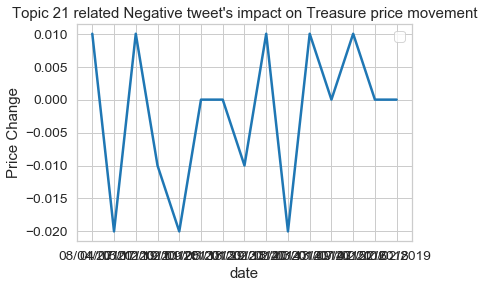

No handles with labels found to put in legend.


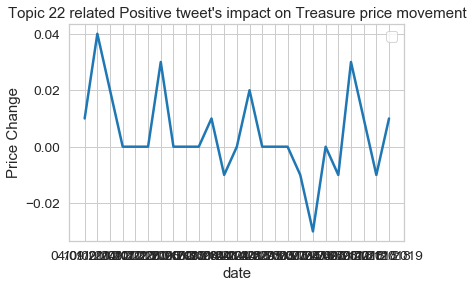

No handles with labels found to put in legend.


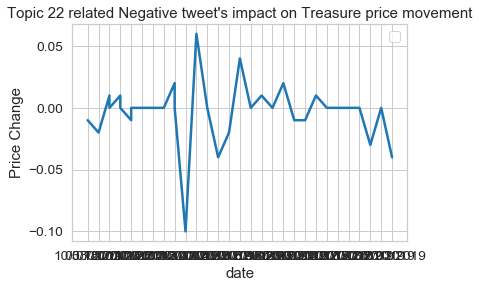

No handles with labels found to put in legend.


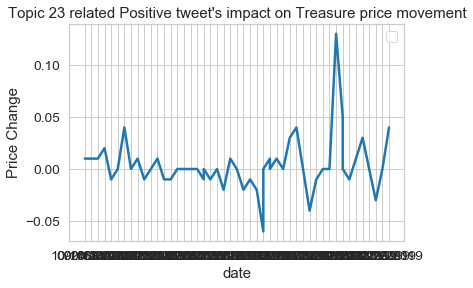

No handles with labels found to put in legend.


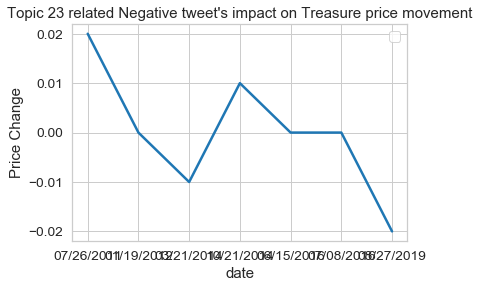

No handles with labels found to put in legend.


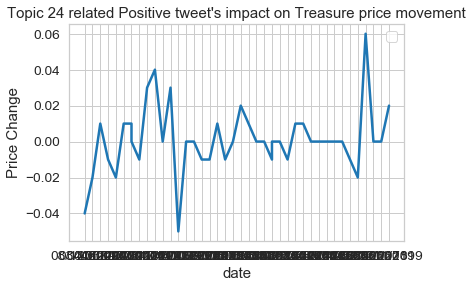

No handles with labels found to put in legend.


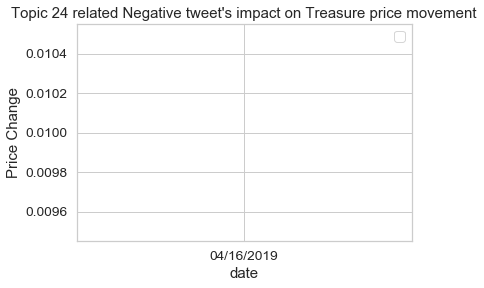

No handles with labels found to put in legend.


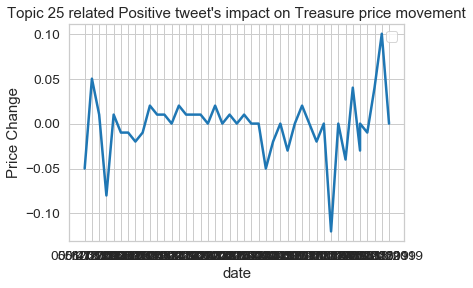

No handles with labels found to put in legend.


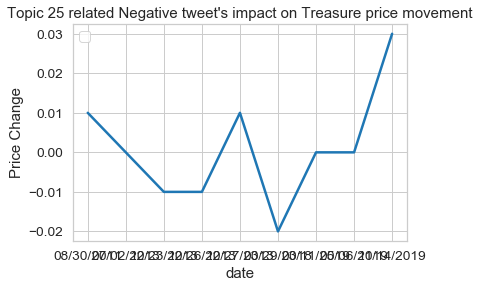

No handles with labels found to put in legend.


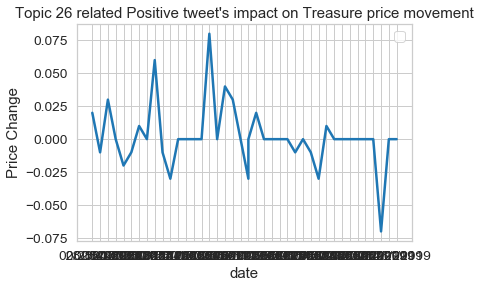

No handles with labels found to put in legend.


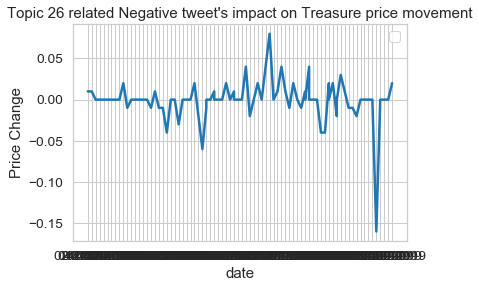

No handles with labels found to put in legend.


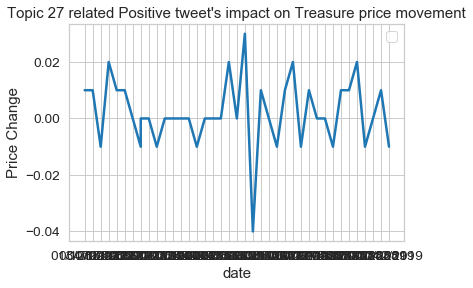

No handles with labels found to put in legend.


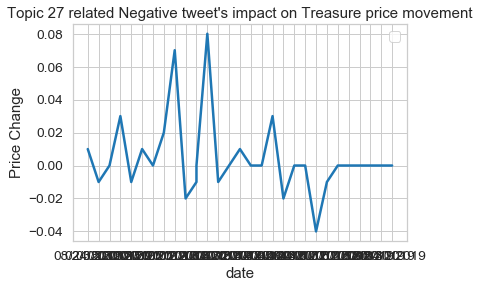

No handles with labels found to put in legend.


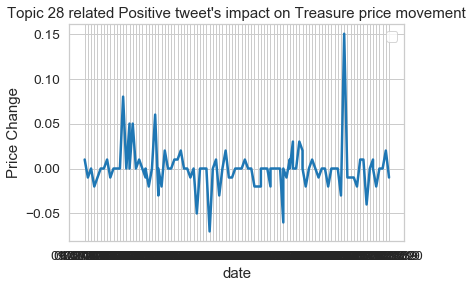

No handles with labels found to put in legend.


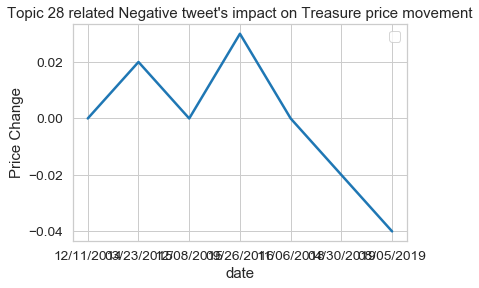

No handles with labels found to put in legend.


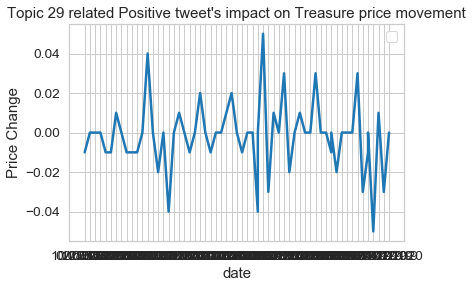

No handles with labels found to put in legend.


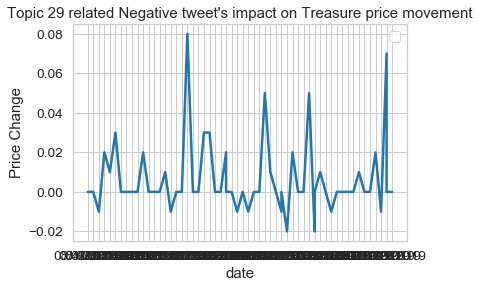

In [24]:
############
#EDA - Topic sentiment impact on price movement
for i in set(list(df6['dominant_topic'])):
    for j in set(list(df6['SA'])):
        df5_1=pd.DataFrame()
        df5_1=df6[(df6['dominant_topic']==i) & (df6['SA']==j)]
        plt.plot(df5_1['date'], df5_1['1 Mo pric diff'])
        plt.xlabel('date')
        plt.ylabel('Price Change')
        plt.title(f"Topic {i} related {j} tweet's impact on Treasure price movement")
        plt.legend()
        plt.show()

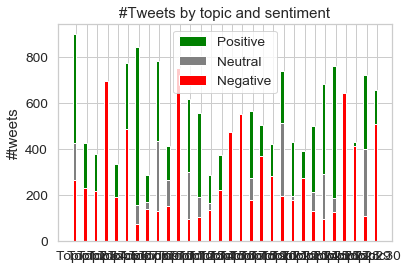

In [25]:
##########################
#reviews_df.head()
df7=Tweet_rate_new[["SA",'dominant_topic']]
df8=pd.pivot_table(df7,columns=["SA"],index=['dominant_topic'],aggfunc=len)

#EDA - #Positive/Neutral/Negative tweets
positive = list(df8['Positive'])
negative = list(df8['Negative'])
neutral = list(df8['Neutral'])

ind = np.arange(len(positive))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, positive, width, label='Positive',color='green')
rects2 = ax.bar(ind - width/2, neutral, width, label='Neutral',color='grey')
rects3 = ax.bar(ind - width/2, negative, width, label='Negative',color='red')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by topic and sentiment')
ax.set_xticks(ind)
ax.set_xticklabels(["Topic"+str(i) for i in range(1,31)])
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


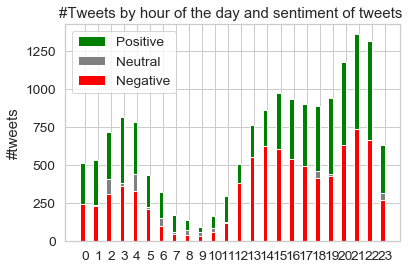

In [26]:
##############
df9=Tweet_rate_new[['hour',"SA"]]
df10=[]
for i in df9['hour']:
    df10.append(int(i))
df9['hour']=df10
#EDA Tweets by hour of the day
df11=pd.pivot_table(df9,columns=["SA"],index=['hour'],aggfunc=len)
positive1 = list(df11['Positive'])
negative1 = list(df11['Negative'])
neutral1 = list(df11['Neutral'])

ind1 = np.arange(len(positive1))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind1 - width/2, positive1, width, label='Positive',color='green')
rects2 = ax.bar(ind1 - width/2, neutral1, width, label='Neutral',color='grey')
rects3 = ax.bar(ind1 - width/2, negative1, width, label='Negative',color='red')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by hour of the day and sentiment of tweets ')
ax.set_xticks(ind1)
ax.set_xticklabels((set(df9['hour'])))
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


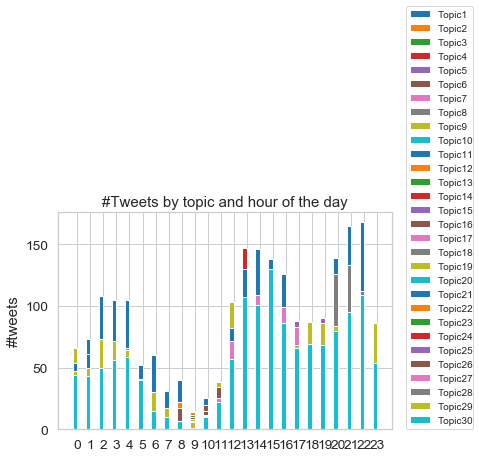

In [27]:
###################
# EDA Tweet sentiment by hour of the day
df10=df9
df10['dominant_topic']=df7['dominant_topic']
df10=df10.drop(['SA'],axis=1)
df12=pd.pivot_table(df10,columns=["dominant_topic"],index=['hour'],aggfunc=len)
Topic1=df12.iloc[:,0]
Topic2=df12.iloc[:,1]
Topic3=df12.iloc[:,2]
Topic4=df12.iloc[:,3]
Topic5=df12.iloc[:,4]
Topic6=df12.iloc[:,5]
Topic7=df12.iloc[:,6]
Topic8=df12.iloc[:,7]
Topic9=df12.iloc[:,8]
Topic10=df12.iloc[:,9]
Topic11=df12.iloc[:,10]
Topic12=df12.iloc[:,11]
Topic13=df12.iloc[:,12]
Topic14=df12.iloc[:,13]
Topic15=df12.iloc[:,14]
Topic16=df12.iloc[:,15]
Topic17=df12.iloc[:,16]
Topic18=df12.iloc[:,17]
Topic19=df12.iloc[:,18]
Topic20=df12.iloc[:,19]
Topic21=df12.iloc[:,20]
Topic22=df12.iloc[:,21]
Topic23=df12.iloc[:,22]
Topic24=df12.iloc[:,23]
Topic25=df12.iloc[:,24]
Topic26=df12.iloc[:,25]
Topic27=df12.iloc[:,26]
Topic28=df12.iloc[:,27]
Topic29=df12.iloc[:,28]
Topic30=df12.iloc[:,29]

ind2 = np.arange(len(Topic1))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind2 - width/2, Topic1, width, label='Topic1')
rects2 = ax.bar(ind2 - width/2, Topic2, width, label='Topic2')
rects3 = ax.bar(ind2 - width/2, Topic3, width, label='Topic3')
rects4 = ax.bar(ind2 - width/2, Topic4, width, label='Topic4')
rects5 = ax.bar(ind2 - width/2, Topic5, width, label='Topic5')
rects6 = ax.bar(ind2 - width/2, Topic6, width, label='Topic6')
rects7 = ax.bar(ind2 - width/2, Topic7, width, label='Topic7')
rects8 = ax.bar(ind2 - width/2, Topic8, width, label='Topic8')
rects9 = ax.bar(ind2 - width/2, Topic9, width, label='Topic9')
rects10 = ax.bar(ind2 - width/2, Topic10, width, label='Topic10')
rects11 = ax.bar(ind2 - width/2, Topic11, width, label='Topic11')
rects12 = ax.bar(ind2 - width/2, Topic12, width, label='Topic12')
rects13 = ax.bar(ind2 - width/2, Topic13, width, label='Topic13')
rects14 = ax.bar(ind2 - width/2, Topic14, width, label='Topic14')
rects15 = ax.bar(ind2 - width/2, Topic15, width, label='Topic15')
rects16 = ax.bar(ind2 - width/2, Topic16, width, label='Topic16')
rects17 = ax.bar(ind2 - width/2, Topic17, width, label='Topic17')
rects18 = ax.bar(ind2 - width/2, Topic18, width, label='Topic18')
rects19 = ax.bar(ind2 - width/2, Topic19, width, label='Topic19')
rects20 = ax.bar(ind2 - width/2, Topic20, width, label='Topic20')
rects21 = ax.bar(ind2 - width/2, Topic21, width, label='Topic21')
rects22 = ax.bar(ind2 - width/2, Topic22, width, label='Topic22')
rects23 = ax.bar(ind2 - width/2, Topic23, width, label='Topic23')
rects24 = ax.bar(ind2 - width/2, Topic24, width, label='Topic24')
rects25 = ax.bar(ind2 - width/2, Topic25, width, label='Topic25')
rects26 = ax.bar(ind2 - width/2, Topic26, width, label='Topic26')
rects27 = ax.bar(ind2 - width/2, Topic27, width, label='Topic27')
rects28 = ax.bar(ind2 - width/2, Topic28, width, label='Topic28')
rects29 = ax.bar(ind2 - width/2, Topic29, width, label='Topic29')
rects30 = ax.bar(ind2 - width/2, Topic30, width, label='Topic30')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('#tweets')
ax.set_title('#Tweets by topic and hour of the day')
ax.set_xticks(ind2)
ax.set_xticklabels((set(df9['hour'])))
ax.legend(loc='best')
plt.legend(bbox_to_anchor=(1.04,0.0,0.2,1), loc='lower left',mode='expand',
           ncol=1, borderaxespad=0.,fontsize=10)
plt.show()

In [28]:
#####################
#Logistic Regression

# Importing the dataset and reading age and salary to X, let's assume we are just looking for this only
df2=df6
df2.columns

df2=df2[['date', 'hour','content', '1 Mo', '1 Mo flag', '1 Mo pric diff',
       'content_processed', 'SA_int', 'SA','dominant_topic']]
df=df2[df2['1 Mo flag'].notna()]
one_hot=pd.get_dummies(df['dominant_topic'])
df=df.drop('dominant_topic',axis=1)
df=df.join(one_hot)
one_hot=pd.get_dummies(df['SA'])
df=df.drop('SA',axis=1)
df=df.join(one_hot)

df_train = df[0:1100]
df_test = df[1100:]

X_train = df_train.iloc[:, 8:].values
y_train = df_train.iloc[:, 4].values

## Splitting the dataset into the Training set and Test set
#from sklearn.model_selection  import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

# Feature Scaling needs to be performed
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)

X_test = df_test.iloc[:, 8:].values
y_test = df_test.iloc[:, 4].values
#X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(300,))
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [29]:
#************************************Evaluating the model***********************************

# Making the Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)

#Validating the Regression Model using the score and it is 89%
# How can you validate the 89% score manually from the confusion matrix
classifier.score(X_test, y_test)

# Calculating the TP,TN,FP and FN ,,, these are used for calculating specificity and sensitivity
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Classification Accuracy: Overall, how often is the classifier correct? Does it match as above
print("Accuracy: {}%".format(((TP + TN)*100 / float(TP + TN + FP + FN)).round(2)))

#Classification Error: Overall, how often is the classifier incorrect? Also known as "Misclassification Rate"
# Why it is 11%
classification_error = ((FP + FN)*100 / float(TP + TN + FP + FN)).round(2)
print("classification_error: {}%".format(classification_error))


#*******Sensitivity**********

sensitivity = TP*100 / float(FN + TP)
print("sensitivity: {}%".format(sensitivity))

#*******Specificity**********
specificity = TN *100/ (TN + FP)
print("specificity: {}%".format(specificity))

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("accuracy_score: {}%".format((accuracy_score(y_test, y_pred)*100).round(2)))

Accuracy: 51.21%
classification_error: 48.79%
sensitivity: 34.17190775681342%
specificity: 65.71428571428571%
[[368 192]
 [314 163]]
              precision    recall  f1-score   support

        down       0.54      0.66      0.59       560
          up       0.46      0.34      0.39       477

    accuracy                           0.51      1037
   macro avg       0.50      0.50      0.49      1037
weighted avg       0.50      0.51      0.50      1037

accuracy_score: 51.21%
